# Problem set 3: DQN, Policy gradient and its variants

**Due: 11:59pm, November 2, 2025**

In the last PSET of reinforcement learning, you will implement the DQN algorithm together with vanilla policy gradient (REINFORCE) and its variants. In the last problem you will train a half-cheetah with stable baseline 3 package. 

- Problem 1 requires implementing DQN and double DQN. **TODOs:**
  
  - 1.1 Finish vanilla DQN (20 pt)
  - 1.2 Finish double DQN (5 pt)

- Problem 2 verify the policy gradient theory and requires implementing REINFORCE with learned value function. **TODOs:**
  
  - 2.1 Verify different policy gradient estimator (15 pt)
  - 2.2 Implement REINFORCE with learned baseline (10 pt)

- Problem 3 requires implementing vanilla on-policy actor-critic algorithm. **TODOs:**
  - 3.1 Implement vanilla actor-critic (25 pt)

All of these three algorithms works on `gym`'s `Acrobot-v1` environments.

- Problem 4 requires implementing PPO algorithm. **TODOs:**
  - 4.1 Implement PPO-cliping (25 pt)

- Problem 5 **(Bonus)** help you try stable baseline 3 on `gym`'s `Half-cheetah-v4` environment. **TODOs:**
  - 5.1 Tune the parameter in stable baseline 3 (**Note the training can take 15 min**) (20 pt)
  

## Problem 1: DQN

In this problem you will implement DQN on `Acrobot-v1` environment using `gym`.

### Algorithm recap

1. **Q-network**
   - Function approximator $Q_\theta(s,a)$ for action values (here: a small MLP).

2. **Target network**
   - A copy of the online network with parameters $\theta^-$ that are updates periodically to stabilize training.

3. **Experience replay**
   - A replay buffer of transitions $(s,a,r,s',\text{done})$. Sample i.i.d. minibatches to break temporal correlations.

4. **Behavior policy**
   - $\epsilon$-greedy: with probability $\epsilon$ choose a random action; otherwise choose $ \arg\max_a Q_\theta(s,a) $.

5. **TD targets**
   - **Standard DQN**:
     $$
     y = r + \gamma \max_{a'} Q_{\theta^-}(s', a')
     $$
   - **Double DQN**:
     $$
     a^\star = \arg\max_{a'} Q_{\theta}(s', a'), \quad
     y = r + \gamma \, Q_{\theta^-}(s', a^\star)
     $$
     “Online net selects, target net evaluates” reduces overestimation. In comparison to Double Q-learning, the weights of the second network $\theta$ are replaced with the weights of the target network $\theta^−$ for the evaluation of the current greedy policy. The update to the target network stays unchanged from DQN, and remains a periodic copy of the online network.

6. **Loss & optimization**
   - Regress $Q_\theta(s,a)$ to target $y$ using MSE loss; backpropagate to update $\theta$.

### Environment & action space

- **Env**: `Acrobot-v1` (double pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/acrobot/)
- **Observation**: 6D —- $\cos\theta_1, \sin\theta_1, \cos\theta_2, \sin\theta_2, \dot\theta_1, \dot\theta_2$  
- **Actions**: Discrete 3 actions —- torques $-1, 0, +1$  
- **Reward**: $-1$ per step until the goal is reached (or the episode times out)


### 1.1 Implement DQN with gym

**TODO:** Fill in the three TODO blocks.
- implement a simple MLP
- implement the replaybuffer class
- implement the main algorithm

All the given code is for reference. If you find it inconvenient feel free to write yourself.

Note the final average return should be around $-100$.

[Env] Acrobot-v1 | obs_dim=6, n_actions=3
Episode 10 | Return: -500.00 | Avg Return: -500.00 | Avg Loss: 6.8593 | Eps: 0.951
Episode 20 | Return: -353.00 | Avg Return: -485.30 | Avg Loss: 10.8519 | Eps: 0.905
Episode 30 | Return: -500.00 | Avg Return: -484.20 | Avg Loss: 11.1172 | Eps: 0.860
Episode 40 | Return: -348.00 | Avg Return: -429.10 | Avg Loss: 8.0195 | Eps: 0.818
Episode 50 | Return: -295.00 | Avg Return: -394.30 | Avg Loss: 6.8804 | Eps: 0.778
Episode 60 | Return: -279.00 | Avg Return: -366.60 | Avg Loss: 8.5754 | Eps: 0.740
Episode 70 | Return: -255.00 | Avg Return: -319.00 | Avg Loss: 6.1911 | Eps: 0.704
Episode 80 | Return: -329.00 | Avg Return: -271.00 | Avg Loss: 5.9328 | Eps: 0.670
Episode 90 | Return: -346.00 | Avg Return: -256.80 | Avg Loss: 4.9844 | Eps: 0.637
Episode 100 | Return: -287.00 | Avg Return: -233.60 | Avg Loss: 5.2454 | Eps: 0.606
Episode 110 | Return: -205.00 | Avg Return: -246.60 | Avg Loss: 4.5546 | Eps: 0.576
Episode 120 | Return: -151.00 | Avg Retur

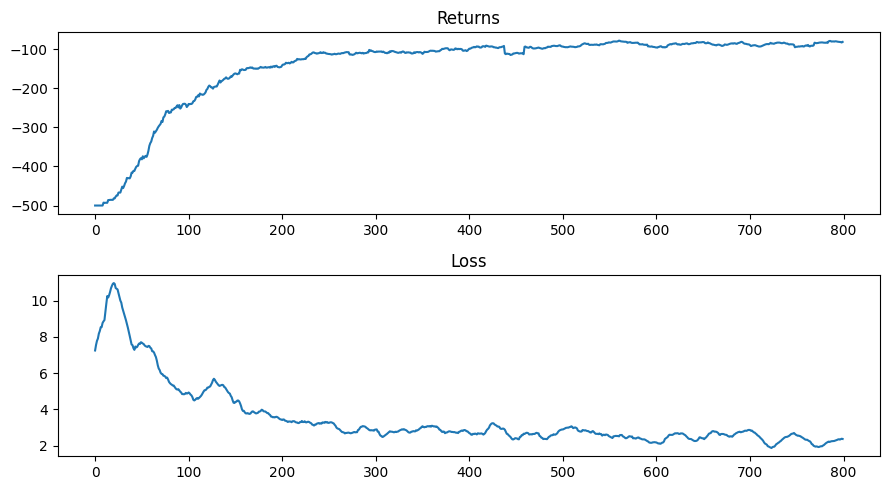

In [69]:

import os, random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import copy

# ------------------- config  -------------------
ENV_ID                 = "Acrobot-v1"
SEED                   = 42
GAMMA                  = 0.995
LR                     = 1e-3
BATCH_SIZE             = 64
BUFFER_SIZE            = 100_000
START_TRAINING_AFTER   = 1000       # warmup steps
TARGET_UPDATE_FREQ     = 10       # steps (hard update)
MAX_EPISODES           = 800

GRAD_CLIP_NORM         = 10.0
PRINT_EVERY_EPISODES   = 10

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

state_dims = int(np.prod(env.observation_space.shape))  # Acrobot: 6
num_actions = env.action_space.n                        # Acrobot: 3
print(f"[Env] {ENV_ID} | obs_dim={state_dims}, n_actions={num_actions}")

# ------------------- gym environment -> tensor -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info

env = TWrapper(env)

# ------------------- Q network -------------------
class QNetwork(nn.Module):
    #########################################
    #TODO 1.1: Implement a simple MLP
    #########################################
    def __init__(self, state_dim, num_actions, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, num_actions)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

q_net = QNetwork(state_dims, num_actions)
tgt_net = copy.deepcopy(q_net).eval()

# ------------------- simple replay buffer -------------------
class ReplayBuffer:
    def __init__(self, capacity=BUFFER_SIZE):
        self.capacity, self.mem, self.pos = capacity, [], 0
    #########################################
    #TODO 1.1: Implement a ReplayBuffer
    # capacity: max number of transitions to store
    # mem: list of transitions
    # pos: next position to insert
    # push: add a transition
    # sample: random sample a batch of transitions
    #########################################
    def push(self, state, action, reward, next_state, done):
        # Store tensors - we'll detach them when sampling to avoid keeping computation graphs
        # But for now, store them as-is so they can participate in future computation graphs
        transition = (state, action, reward, next_state, done)
        if len(self.mem) < self.capacity:
            self.mem.append(transition)
        else:
            self.mem[self.pos] = transition
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.mem, batch_size)
        # Concatenate tensors
        # Note: If tensors were detached when stored, they're already detached
        # When we use detached tensors as input to networks, gradients still flow through network parameters
        states = torch.cat([t[0] for t in batch], dim=0)
        actions = torch.cat([t[1] for t in batch], dim=0)
        rewards = torch.cat([t[2] for t in batch], dim=0)
        next_states = torch.cat([t[3] for t in batch], dim=0)
        dones = torch.cat([t[4] for t in batch], dim=0)
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.mem)
    
buffer = ReplayBuffer()
optim  = Adam(q_net.parameters(), lr=LR)

# ------------------- greedy / epsilon-greedy -------------------
@torch.no_grad()
def act_epsilon_greedy(state: torch.Tensor, eps: float) -> torch.Tensor:
    if torch.rand(1).item() < eps:
        return torch.randint(num_actions, (1, 1))
    q = q_net(state)
    return torch.argmax(q, dim=-1, keepdim=True)

# ------------------- train loop (Double DQN target) -------------------
def train():
    # Ensure gradients are enabled globally
    torch.set_grad_enabled(True)
    
    q_net.train()  # Ensure network is in training mode
    # Verify all parameters require gradients
    for name, param in q_net.named_parameters():
        if not param.requires_grad:
            print(f"Warning: {name} does not require grad! Enabling gradients.")
            param.requires_grad = True
    
    returns_hist, loss_hist = [], []
    eps = 1.0
    eps_decay = 0.995
    eps_min = 0.01
    step_count = 0

    for ep in range(1, MAX_EPISODES + 1):
        #########################################
        #TODO 1.1: Implement the main algorithm here
        #########################################
        state, _ = env.reset()
        ep_return = 0.0
        ep_losses = []
        done = False
        
        while not done:
            # Epsilon-greedy action selection
            action = act_epsilon_greedy(state, eps)
            next_state, reward, done, _ = env.step(action)
            
            # Store transition
            buffer.push(state, action, reward, next_state, done)
            state = next_state
            ep_return += reward.item()
            step_count += 1
            
            # Training step
            if len(buffer) >= START_TRAINING_AFTER and step_count % 1 == 0:
                # Sample batch
                states, actions, rewards, next_states, dones = buffer.sample(BATCH_SIZE)
                
                # Create completely fresh tensors from the data to ensure clean computation graph
                # Convert to numpy first, then back to tensor - this creates truly fresh leaf tensors
                states_np = states.detach().cpu().numpy()
                states = torch.tensor(states_np, dtype=states.dtype, device=states.device)
                
                next_states_np = next_states.detach().cpu().numpy()
                next_states = torch.tensor(next_states_np, dtype=next_states.dtype, device=next_states.device)
                
                # Verify network parameters require grad
                if not any(p.requires_grad for p in q_net.parameters()):
                    raise RuntimeError("No network parameters require grad!")
                
                # Compute Q-values for current states
                q_values = q_net(states)
                
                # Ensure actions are long integers for gather
                actions_long = actions.long() if actions.dtype != torch.long else actions
                q_value = q_values.gather(1, actions_long)
                
                # Verify q_value requires grad
                if not q_value.requires_grad:
                    raise RuntimeError("q_value should require grad for backpropagation")
                
                # Compute targets (no gradients needed)
                with torch.no_grad():
                    #########################################
                    #TODO 1.2: Change from DQN to Double DQN
                    #########################################
                    # Standard DQN (commented out):
                    next_q_values = tgt_net(next_states)
                    next_q_value = next_q_values.max(1, keepdim=True)[0]
                    
                    # Double DQN: online net selects, target net evaluates
                    # next_q_values_online = q_net(next_states)
                    # next_actions = next_q_values_online.argmax(1, keepdim=True)
                    # next_q_values_target = tgt_net(next_states)
                    # next_q_value = next_q_values_target.gather(1, next_actions)
                    
                    target = rewards + (GAMMA * next_q_value * (~dones))
                
                # Ensure target doesn't require grad (safeguard)
                target = target.detach()
                
                # Compute loss
                loss = F.mse_loss(q_value, target)
                
                # Verify loss requires grad
                if not loss.requires_grad:
                    raise RuntimeError("loss should require grad for backpropagation")
                ep_losses.append(loss.item())
                
                # Optimize
                optim.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(q_net.parameters(), GRAD_CLIP_NORM)
                optim.step()
                
                # Update target network
                if step_count % TARGET_UPDATE_FREQ == 0:
                    tgt_net.load_state_dict(q_net.state_dict())
        
        # Update epsilon
        eps = max(eps_min, eps * eps_decay)
        
        # Record statistics
        returns_hist.append(ep_return)
        if ep_losses:
            loss_hist.append(np.mean(ep_losses))
        else:
            loss_hist.append(0.0)
        
        # Print progress
        if ep % PRINT_EVERY_EPISODES == 0:
            avg_return = np.mean(returns_hist[-PRINT_EVERY_EPISODES:])
            avg_loss = np.mean(loss_hist[-PRINT_EVERY_EPISODES:]) if loss_hist[-PRINT_EVERY_EPISODES:] else 0.0
            print(f"Episode {ep} | Return: {ep_return:.2f} | Avg Return: {avg_return:.2f} | Avg Loss: {avg_loss:.4f} | Eps: {eps:.3f}")
        
    plot_stats({"Returns": returns_hist, "Loss": loss_hist})

# ------------------- plotting -------------------
def _smooth(x, w=21):
    if len(x) < w: return x
    k = w // 2
    return [np.mean(x[max(0, i-k):min(len(x), i+k+1)]) for i in range(len(x))]

def plot_stats(stats: dict, win: int = 21):
    fig, axs = plt.subplots(len(stats), 1, figsize=(9, 5), tight_layout=True)
    if len(stats) == 1: axs = [axs]
    for ax, (k, v) in zip(axs, stats.items()):
        ax.plot(_smooth(v, win))
        ax.set_title(k)
    plt.show()
    plt.close()

train()
env.close()


### 1.2 Change classical DQN to double DQN

Use **two networks**:
- **Online** network selects the next action  
  $$
  a^* = \arg\max_{a'} Q_{\text{online}}(s', a').
  $$
- **Target** network evaluates that action  
  $$
  y_{\text{DDQN}} = r + \gamma\, Q_{\text{target}}(s', a^*).
  $$
  
This decoupling reduces overestimation while keeping the update otherwise unchanged.

In the code you will only need to change several lines. 

**TODO:** Comment the vanilla DQN and write Double DQN at the same place.

## Problem 2: Policy Gradient

<!-- #### reparameterization trick:

Let $x$ be a random variable whose distribution depends on $\theta$. Write this as $x\sim p_\theta(x)$. For any measurable $V:\mathcal X\to\mathbb R$,
$$
\mathbb{E}\big[V(f(\theta))\big] \;=\; \mathbb{E}_{x\sim p_\theta}[V(x)],
$$
where $p_\theta$ is the distribution of $x$ induced by $\theta$. This help us move complex functions from expectation to distribution.

Take the gradient gives us

$$
\nabla \mathbb{E}_{x\sim p_\theta}[V(x)] = \int \nabla p_\theta(x) V(x) dx = \int \nabla \ln(p_\theta(x)) V(x) p_\theta(x)dx = \mathbb{E}_{x\sim p_\theta}[V(x) \nabla \ln(p_\theta(x))]
$$

So now we only need to take derivative of the distribution.

### RL as an Expectation over Trajectories
The cost over a distribution of $s_0$ gives the definition of reward function $J$:

$$
\mathbb{E}_{s_0\sim\rho}[V^{\pi_\theta}(s_0)]
$$

But use the trick above we can rewrite that using trajectory. A trajectory is
$$
\tau=(s_0,a_0,s_1,a_1,\ldots,s_T),
$$
generated by initial state distribution $\rho$, policy $\pi_\theta(a\mid s)$, and dynamics $P(s'\mid s,a)$. The trajectory distribution is
$$
p_\theta(\tau)=\rho(s_0)\prod_{t=0}^{T-1}\pi_\theta(a_t\mid s_t)\,P(s_{t+1}\mid s_t,a_t).
$$
Define the discounted return
$$
G(\tau)=\sum_{t=0}^{T-1}\gamma^t\,r(s_t,a_t).
$$
Then the performance objective is
$$
\,J(\theta)=\mathbb{E}_{\tau\sim p_\theta}[G(\tau)]\,
$$

This helps move the $\theta$ to distribution.
 -->

### Recall: Policy-Gradient Theorem

$$
\begin{aligned}
\nabla_\theta J(\theta)
&= \nabla_\theta \mathbb{E}_{\tau\sim p_\theta}[G(\tau)]
= \mathbb{E}_{\tau\sim p_\theta}\!\left[G(\tau)\,\nabla_\theta\log p_\theta(\tau)\right] \\
&= \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t\mid s_t)\,G(\tau)\right] \\
\end{aligned} \tag{F1}
$$

This is the first gradient formulation we arrive at (here $G(\tau) = R(\tau)$ and $R(\tau)$ is the notation used in Lecture notes). A naive collary is the using causality to change that to return-to-go:

$$
\begin{aligned}
\nabla_\theta J(\theta)
&= \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,G_t(\tau)\right]
\end{aligned} \tag{F2} 
$$

where $G_t=\sum_{k=t}^{T-1}\gamma^{k-t}r(s_k,a_k)$ and $d^{\pi_\theta}$ is the discounted state-visitation distribution. Next, we observe that 

$$
\mathbb{E}_{a_t\sim\pi_\theta}\!\left[\nabla_\theta\log\pi_\theta(a_t\mid s_t)\,b(s_t)\right]=0,
$$

<!-- This is because condition on $s_t$, $b(s_t)$ is a constant inside expectation, and $\mathbb{E}_{a_t\sim\pi_\theta}\!\left[\nabla_\theta\log\pi_\theta(a_t\mid s_t)\right]=0$.  -->

Plug in the "baseline" $b(s_t)$ into the policy gradient gives us

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,(G_t(\tau)- b(s_t))\right] \tag{F3}
$$

In practice most of the time people use the learned value function for the baseline.

### Policy gradient theorem (extended)

Next we talk about another 3 chosen of policy gradient:

From (F2) gradient we can easily see that $Q(s_t,a_t) = \mathbb{E}[G_t(\tau)]$, so plug in F2 gives us
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,Q(s_t,a_t)\right] \tag{F4}
$$

And followed by previous explanation of baseline, we can define $A(s_t,a_t) = Q(s_t,a_t) - V(s_t)$, thus we arrive the *advantage function* gradient.
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,A(s_t,a_t)\right] \tag{F5}
$$

The last formulation is by observing that
$$
\mathbb{E}[Q(s_t,a_t)] = \mathbb{E}[r(s_t,a_t) + \gamma V(s_{t+1})]
$$

apply baseline to it gives us
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,(r(s_t,a_t) + \gamma V(s_{t+1}) - V(s_t))\right] \tag{F6}
$$

### 2.1 Convergence of Different Policy-Gradient Estimators

We study a random walk on a ring. Let $\mathcal{S}=\mathbb{Z}_N$ and $\mathcal{A}=\{L,R\}$. The dynamics and rewards are
$$
s_{t+1}\equiv s_t+\begin{cases}
+1 & \text{if }a_t = R, \\
-1 & \text{if }a_t = L,
\end{cases}\ (\mathrm{mod}\,N),\qquad
r_t \equiv \begin{cases}
r_\text{terminal} & \text{if done} \\
r_\text{step} & \text{otherwise}
\end{cases},\quad \gamma\in(0,1).
$$

Because this is tabular, Bellman consistency (Eq. 1.21) yields a linear system $AV=b$ (as in PSET1, Problem 4). Solving gives the exact values $V$, and $Q$ follows by one-step lookahead.

**TODO:**
1. Implement a minimal MLP policy ($x=s/N\to\pi_\theta(\cdot\mid s)$) with a Softmax output.  
2. Implement six MC gradient estimators: REINFORCE, return-to-go, baseline with $V$, using $Q$, advantage $Q{-}V$, and TD-residual.  
3. Plot per-parameter sample std and the running-mean error $\|\bar g_k-\nabla_\theta J\|_2$ vs. episodes, plus $|\bar J_k-J_{\text{true}}|$.
   $$\bar g_k = \frac{1}{k} \sum_i^k g_i, \quad \bar J_k = \frac{1}{k} \sum_i^k J_i$$
   
4. Comment on what you see, and explain it intuitively.

Note:

Here we provide the function `build_system`, `get_V_and_J` and `get_Q` for calculate the true value / action value. `finite_difference_grad` for approximate the true objective / gradient by finite difference. And also `logp_single` and `score_matrix_batch` for calculate $\nabla J_\theta$ in a batched manner (You can also use for-loop, but that takes quite long run time). But feel free to use your own code.


Starting Problem 2.1: Policy Gradient Estimators
[main] Using device: cpu
[main] Environment: N=10, gamma=0.9, running_reward=-1.0, terminal_reward=100.0
[main] Creating PolicyNet with hidden=2...
[main] Model created with 16 total parameters
[main] Model device: cpu
[main] Computing exact J and finite-difference gradient...
[build_system] N=10, device=cpu
[build_system] s_idx shape: torch.Size([9])
[build_system] x (before reshape) shape: torch.Size([9])
[build_system] x (after reshape) shape: torch.Size([9, 1])
[build_system] First layer input dim: 1, output dim: 2
[PolicyNet.forward] Input x shape: torch.Size([9, 1])
[PolicyNet.forward] fc1 weight shape: torch.Size([2, 1]), bias shape: torch.Size([2])
[build_system] pi shape: torch.Size([9, 2])
[build_system] p shape: (9,), mean p(right): 0.578
[build_system] N=10, device=cpu
[build_system] s_idx shape: torch.Size([9])
[build_system] x (before reshape) shape: torch.Size([9])
[build_system] x (after reshape) shape: torch.Size([9, 1])

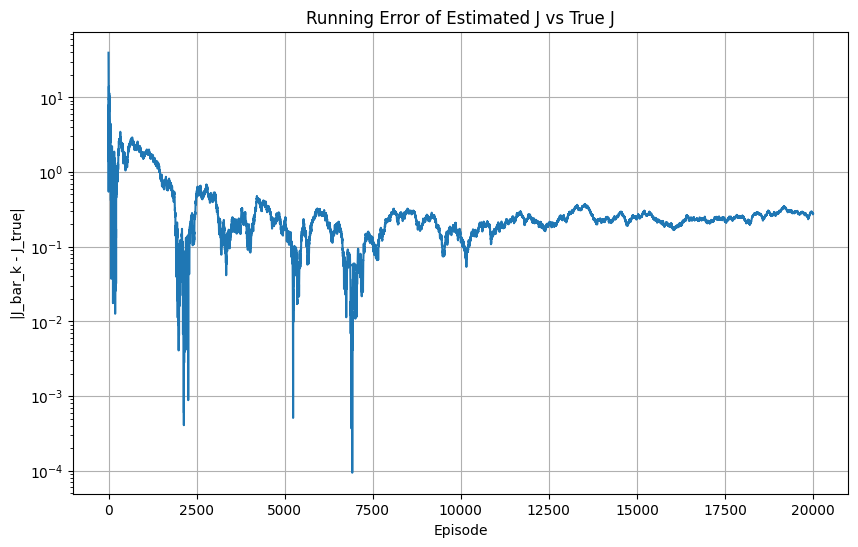

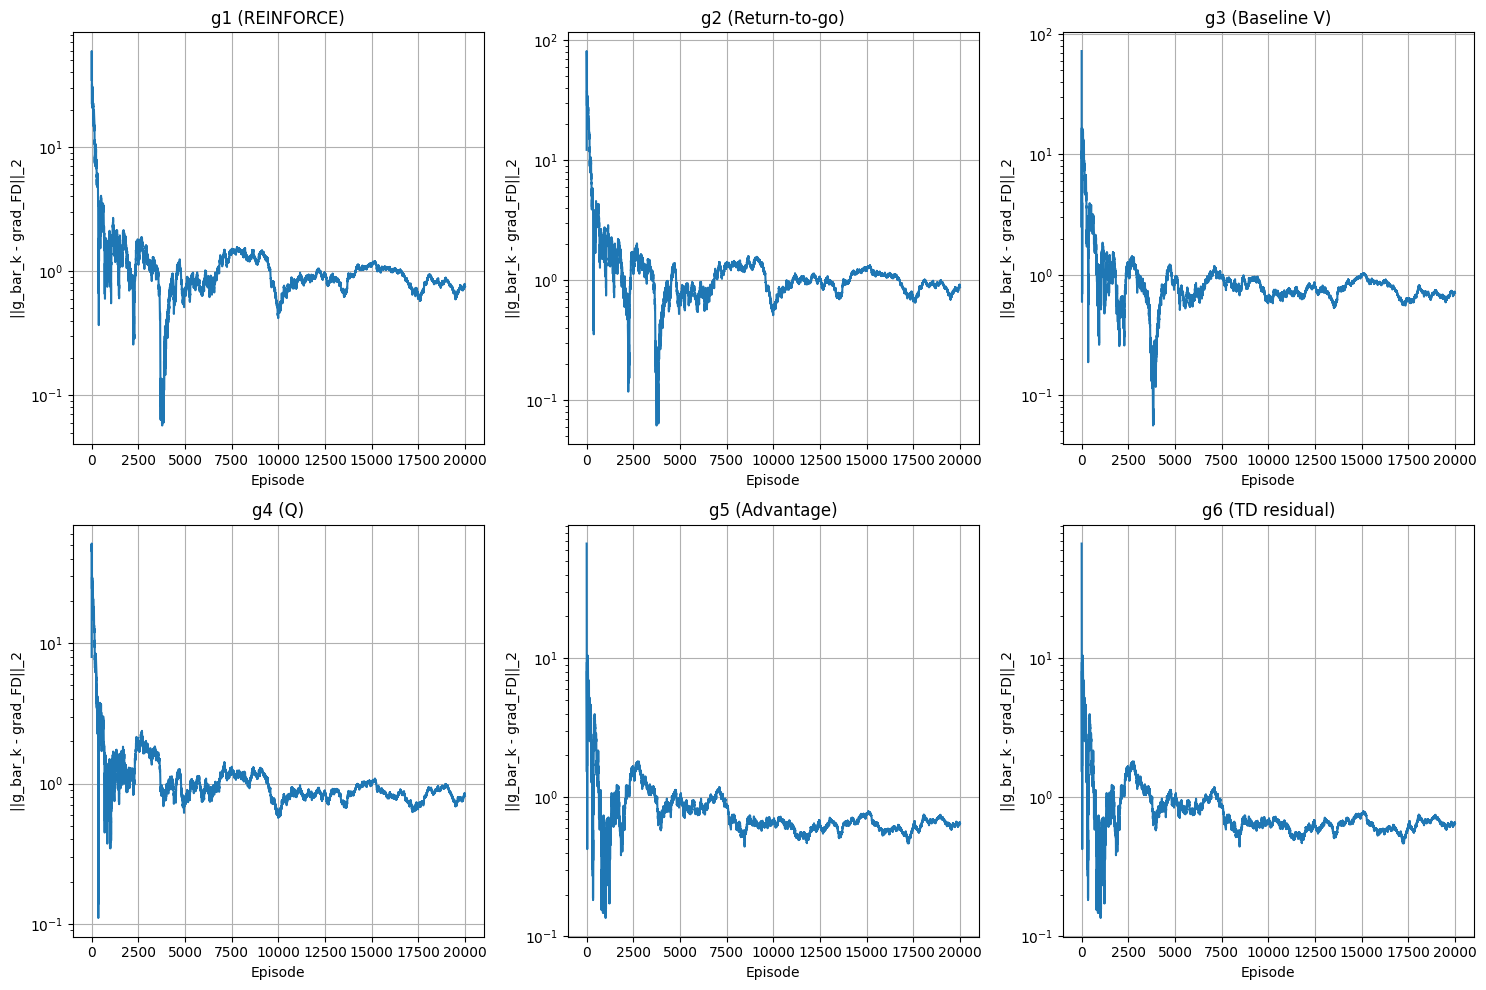

In [2]:
import math, random
import gc
from typing import Tuple, List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt
from torch.func import functional_call, vmap, jacrev


# ----------------- utilities -----------------
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# ----------------- policy network (last layer Softmax) -----------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 2.1: Implement the policy network
    #########################################
    def __init__(self, hidden=32):
        super().__init__()
        # Input: normalized state s/N (scalar, shape: [B, 1])
        # Output: logits for 2 actions (Left, Right), then Softmax
        self.fc1 = nn.Linear(1, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 2)  # 2 actions: Left (0), Right (1)
    
    def forward(self, x):
        # x: [B, 1] normalized state
        if not hasattr(self, '_debug_printed'):
            print(f"[PolicyNet.forward] Input x shape: {x.shape}")
            print(f"[PolicyNet.forward] fc1 weight shape: {self.fc1.weight.shape}, bias shape: {self.fc1.bias.shape}")
            self._debug_printed = True
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        logits = self.fc3(x)
        probs = F.softmax(logits, dim=-1)  # [B, 2]
        return probs
    

# ----------------- DP: exact J(θ) using policy p_s -----------------
def build_system(model: PolicyNet, N: int, gamma: float,
                 running_reward: float, terminal_reward: float):
    """
    In tabular case, we could build A,b directly from the bellman's equations (eq 1.21 in lecture note).
    Build linear system A V = b for states s=1..N-1.
    Transition probabilities p_s come from the torch policy (Right prob).
    """
    model.eval()
    device = next(model.parameters()).device
    print(f"[build_system] N={N}, device={device}")
    with torch.no_grad():
        s_idx = torch.arange(1, N, dtype=torch.float32, device=device)
        print(f"[build_system] s_idx shape: {s_idx.shape}")
        x = s_idx / float(N)                  # (N-1,)
        print(f"[build_system] x (before reshape) shape: {x.shape}")
        x = x.view(-1, 1)                     # Reshape to (N-1, 1) explicitly
        print(f"[build_system] x (after reshape) shape: {x.shape}")
        print(f"[build_system] First layer input dim: {model.fc1.in_features}, output dim: {model.fc1.out_features}")
        pi = model(x)                         # (N-1, 2)
        print(f"[build_system] pi shape: {pi.shape}")
        p = pi[:, 1].cpu().numpy()            # P(right | s)
        q = (1.0 - p)                         # P(left  | s)
        print(f"[build_system] p shape: {p.shape}, mean p(right): {p.mean():.3f}")

    A = np.zeros((N-1, N-1), dtype=np.float64)
    b = np.zeros(N-1, dtype=np.float64)

    if N - 1 == 1:
        A[0, 0] = 1.0
        b[0] = terminal_reward
        return A, b

    # s = 1 (index 0)
    A[0, 0] = 1.0
    A[0, 1] = -gamma * p[0]
    b[0] = q[0] * terminal_reward + p[0] * running_reward

    # s = 2..N-2 (indices 1..N-3)
    for s in range(2, N-1):
        i = s - 1
        A[i, i]   = 1.0
        A[i, i-1] = -gamma * q[i]
        A[i, i+1] = -gamma * p[i]
        b[i]      = running_reward

    # s = N-1 (index N-2)
    i = N - 2
    A[i, i]   = 1.0
    A[i, i-1] = -gamma * q[i]
    b[i]      = p[i] * terminal_reward + q[i] * running_reward
    return A, b

def get_V_and_J(model: PolicyNet, N: int, gamma: float,
                running_reward: float, terminal_reward: float):
    """Solve A V = b; return V(s) for s=1..N-1 and uniform-start J."""
    A, b = build_system(model, N, gamma, running_reward, terminal_reward)
    V = np.linalg.solve(A, b)
    return V, float(V.mean())

def get_Q(model: PolicyNet, N: int, gamma: float,
          running_reward: float, terminal_reward: float):
    """
    Q(s,a) via one-step lookahead using V from DP.
    Returns Q for s=1..N-1 (shape (N-1, 2)).
    """
    V, _ = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
    V_full = np.zeros(N + 1)
    V_full[1:N] = V
    s = np.arange(1, N, dtype=np.int64)
    sL, sR = s - 1, s + 1
    rL = np.where(sL == 0, terminal_reward, running_reward)
    rR = np.where(sR == N, terminal_reward, running_reward)
    Q = np.empty((N-1, 2), dtype=np.float64)
    Q[:, 0] = rL + gamma * V_full[sL]
    Q[:, 1] = rR + gamma * V_full[sR]
    return Q

# ----------------- Finite-difference gradient on θ (torch) -----------------
def finite_difference_grad(model: PolicyNet, N: int, gamma: float,
                           running_reward: float, terminal_reward: float,
                           eps: float = 1e-4, relative: bool = False,
                           scheme: str = 'central'):
    """
    Finite-difference ∇θ J where θ is the concatenated torch parameter vector.
    Supports central or forward difference. Optional relative step size.
    """
    theta0 = parameters_to_vector(model.parameters()).detach().clone()
    _, J0 = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
    grad = torch.zeros_like(theta0)

    for i in range(theta0.numel()):
        base = float(abs(theta0[i])) if relative else 1.0
        h = eps * max(1.0, base)

        if scheme.lower() == 'central':
            th_p = theta0.clone(); th_p[i] += h
            th_m = theta0.clone(); th_m[i] -= h
            vector_to_parameters(th_p, model.parameters())
            Jp = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            vector_to_parameters(th_m, model.parameters())
            Jm = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            grad[i] = (Jp - Jm) / (2.0 * h)
        elif scheme.lower() == 'forward':
            th_p = theta0.clone(); th_p[i] += h
            vector_to_parameters(th_p, model.parameters())
            Jp = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            grad[i] = (Jp - J0) / h
        else:
            raise ValueError("scheme must be 'central' or 'forward'")

    # restore original params
    vector_to_parameters(theta0, model.parameters())
    return J0, grad.detach()

# ----------------- MC gradient estimators (REINFORCE family) -----------------
def mc_grad_estimators(model: PolicyNet, N: int, s0_batch: torch.Tensor, gamma: float,
                       step_cost: float, terminal_reward: float,
                       V: torch.Tensor = None, Q: torch.Tensor = None):
    """
    We compute per-sample score vectors using autograd by calling backward()
    on log π(a_t|s_t) to obtain ∇θ log π(a_t|s_t).

    Returns (all numpy arrays):
      g1..g6: (B, P) per-episode gradient samples; J: (B,)
        g1: full-return REINFORCE
        g2: return-to-go REINFORCE (via cumulative scores H)
        g3: baseline with V(s_t)
        g4: use Q(s_t, a_t)
        g5: use Advantage A = Q − V
        g6: use TD residual δ_t = r_t + γ V(s_{t+1}) − V(s_t)
    """
    device = next(model.parameters()).device
    model.eval()
    
    print(f"[mc_grad_estimators] Starting with N={N}, gamma={gamma}")
    print(f"[mc_grad_estimators] device={device}")
    
    names, base_params = zip(*list(model.named_parameters()))
    # Detach so these are leaf tensors, then turn grad on (required by jacrev)
    params = tuple(p.detach().requires_grad_(True) for p in base_params)
    P = sum(p.numel() for p in params)
    print(f"[mc_grad_estimators] Number of parameters P={P}")

    B = int(s0_batch.numel())
    print(f"[mc_grad_estimators] Batch size B={B}")
    s    = s0_batch.to(device).clone()
    done = (s == 0) | (s == N)
    print(f"[mc_grad_estimators] Initial states shape: {s.shape}, initial done count: {done.sum().item()}")
    
    if V is not None:
        print(f"[mc_grad_estimators] V provided, shape: {V.shape}")
    if Q is not None:
        print(f"[mc_grad_estimators] Q provided, shape: {Q.shape}")

    H  = torch.zeros(B, P, device=device)  # cumulative score per-episode
    g1 = torch.zeros(B, P, device=device)
    g2 = torch.zeros(B, P, device=device)
    g3 = torch.zeros(B, P, device=device)
    g4 = torch.zeros(B, P, device=device)
    g5 = torch.zeros(B, P, device=device)
    g6 = torch.zeros(B, P, device=device)
    J  = torch.zeros(B,   device=device)
    gpw= torch.ones (B,   device=device)  # γ^t
    
    # Track trajectory for computing return-to-go properly
    rewards_traj = []  # List of reward tensors per step
    scores_traj = []   # List of score tensors per step  
    states_traj = []   # List of state tensors per step
    actions_traj = []  # List of action tensors per step
    active_mask_traj = []  # Which episodes were active at each step

    if V is not None:
        V = V.to(device)     # shape N+1, suggest V[0]=V[N]=0
    if Q is not None:
        Q = Q.to(device)     # shape (N+1,2), with Q(0,.)=Q(N,.)=0 if you padded
    
    def logp_single(param_tensors, s_scalar: torch.Tensor, a_scalar: torch.Tensor):
        # Build a param dict for functional_call
        pmap = {n: t for n, t in zip(names, param_tensors)}
        x = (s_scalar.float() / float(N)).view(1, 1)
        probs = functional_call(model, pmap, (x,))    # (1,2)
        # Differentiable action selection via gather (avoid data-dependent indexing pitfalls)
        logp = probs.log().gather(1, a_scalar.long().view(1, 1)).squeeze()  # scalar
        return logp

    # Note: you may found this function useful, this calculate ∇θ log π(a_i|s_i) in a batch manner
    def score_matrix_batch(active_s: torch.Tensor, active_a: torch.Tensor) -> torch.Tensor:
        """
        Returns (B_act, P) where each row is ∇θ log π(a_i|s_i),
        computed efficiently via vmap(jacrev) over (s,a).
        """
        # jac is a pytree of tensors matching param shapes, each with leading dim B_act
        jac = vmap(jacrev(logp_single), in_dims=(None, 0, 0))(params, active_s, active_a)
        # Flatten each param’s jacobian and concatenate along feature dim
        parts = [g.reshape(g.shape[0], -1) for g in jac]
        return torch.cat(parts, dim=1)  # (B_act, P)


    step_count = 0
    while not torch.all(done):
        step_count += 1
        idx = (~done).nonzero(as_tuple=False).squeeze(1)
        if idx.numel() == 0:
            break
        
        if step_count % 1000 == 0:
            print(f"[mc_grad_estimators] Step {step_count}, active episodes: {idx.numel()}/{B}, done: {done.sum().item()}")

        # Sample actions for all active states in one forward pass
        x = (s[idx].float() / float(N)).unsqueeze(1)
        with torch.no_grad():
            probs = model(x)                            # (B_act, 2)
            a = torch.multinomial(probs, 1).squeeze(1) # (B_act,)

        # ∇θ log π(a|s): (B_act, P) using backward()
        score_mat = score_matrix_batch(s[idx], a)

        # Next state, termination, and rewards
        s_next   = s[idx] + torch.where(a == 1, 1, -1)
        term_any = (s_next == 0) | (s_next == N)
        r_t = torch.where(
            term_any,
            torch.tensor(terminal_reward, device=device),
            torch.tensor(step_cost, device=device)
        ).float()
        
        #########################################
        #TODO 2.1: Implement the six policy gradient estimators
        #########################################
        # Store trajectory data for computing return-to-go
        # CRITICAL: Detach when storing to avoid keeping computation graphs in memory!
        # This prevents memory bloat from storing gradient history
        rewards_traj.append(r_t.detach().clone())
        scores_traj.append(score_mat.detach().clone())  # score_mat has gradients - must detach!
        states_traj.append(s[idx].detach().clone())
        actions_traj.append(a.detach().clone())
        active_mask_traj.append(idx.detach().clone())
        
        # Detach score_mat immediately to avoid building massive computation graphs
        # We need score_mat for this step's computations, then we can detach
        score_mat_detached = score_mat.detach()
        
        # Accumulate cumulative score: H[idx] += score_mat (keep gradients for final g1)
        # Note: This builds a computation graph, but it's necessary for REINFORCE
        # We'll handle this by computing g1 from stored scores if memory is an issue
        H[idx] += score_mat
        
        # Update returns: J[idx] += γ^t * r_t (total return) - detach r_t to avoid graph growth
        J[idx] += gpw[idx] * r_t.detach()
        
        # Current state values (if V available)
        v_curr = V[s[idx]] if V is not None else None
        v_next = V[s_next] if V is not None else None
        
        # Current Q-values (if Q available)
        q_sa = None
        if Q is not None:
            # Q[s, a] where s is current state, a is action taken
            q_sa = torch.where(a == 1, Q[s[idx], 1], Q[s[idx], 0])  # [B_act]
        
        # Update g4: Use Q(s_t, a_t) * γ^t * ∇log π
        # Use detached score_mat to avoid building computation graphs over thousands of steps
        if Q is not None and q_sa is not None:
            g4[idx] += (q_sa.unsqueeze(1) * gpw[idx].unsqueeze(1) * score_mat_detached).detach()
        
        # Update g5: Advantage A = Q(s_t, a_t) - V(s_t) * γ^t * ∇log π
        if Q is not None and V is not None and q_sa is not None and v_curr is not None:
            advantage = q_sa - v_curr  # [B_act]
            g5[idx] += (advantage.unsqueeze(1) * gpw[idx].unsqueeze(1) * score_mat_detached).detach()
        
        # Update g6: TD residual δ_t = r_t + γV(s_{t+1}) - V(s_t) * γ^t * ∇log π
        if V is not None and v_curr is not None and v_next is not None:
            td_residual = r_t.detach() + gamma * v_next - v_curr  # [B_act]
            g6[idx] += (td_residual.unsqueeze(1) * gpw[idx].unsqueeze(1) * score_mat_detached).detach()
        
        # Update discount factor for next step
        gpw[idx] *= gamma
        
        # Update states
        s[idx] = s_next
        done[idx] = term_any
    
    print(f"[mc_grad_estimators] Loop finished after {step_count} steps")
    print(f"[mc_grad_estimators] Total trajectory steps recorded: {len(rewards_traj)}")
    print(f"[mc_grad_estimators] Processing {B} episodes for return-to-go computation...")
    
    # After all episodes finish, compute g1, g2, g3 using full trajectories
    # For each episode, compute return-to-go backward and accumulate gradients
    episodes_processed = 0
    for ep_idx in range(B):
        # Find when this episode was active and its position in active batch
        episode_steps = []
        for step_idx in range(len(rewards_traj)):
            active_indices = active_mask_traj[step_idx]
            mask = (active_indices == ep_idx)
            if mask.any():
                pos_in_active = mask.nonzero(as_tuple=False)[0].item()
                episode_steps.append((step_idx, pos_in_active))
        
        if len(episode_steps) == 0:
            continue
            
        # Compute return-to-go backward: G_t = r_t + γ * G_{t+1}
        returns_to_go = []
        G = 0.0
        for i in range(len(episode_steps) - 1, -1, -1):
            step_idx, pos_idx = episode_steps[i]
            r = rewards_traj[step_idx][pos_idx].item()
            G = r + gamma * G
            returns_to_go.insert(0, G)
        
        # Accumulate gradients for this episode
        discount = 1.0
        for i, (step_idx, pos_idx) in enumerate(episode_steps):
            score = scores_traj[step_idx][pos_idx:pos_idx+1]  # [1, P]
            G_t = returns_to_go[i]
            
            # g2: Return-to-go REINFORCE - G_t * γ^t * ∇log π
            g2[ep_idx] += discount * G_t * score.squeeze(0)
            
            # g3: Baseline with V - (G_t - V(s_t)) * γ^t * ∇log π
            if V is not None:
                s_val = int(states_traj[step_idx][pos_idx].item())
                v_s = V[s_val].item()
                g3[ep_idx] += discount * (G_t - v_s) * score.squeeze(0)
            
            discount *= gamma
        
        episodes_processed += 1
        if episodes_processed % 5000 == 0:
            print(f"[mc_grad_estimators] Processed {episodes_processed}/{B} episodes...")
    
    print(f"[mc_grad_estimators] Finished processing all {episodes_processed} episodes")
    
    # Set g1: Full return REINFORCE = G(τ) * Σ_t ∇log π
    # Compute in chunks to avoid memory issues with large tensors
    print(f"[mc_grad_estimators] Computing g1 from J and H...")
    print(f"[mc_grad_estimators] J shape: {J.shape}, H shape: {H.shape}")
    
    # Compute g1 in a memory-efficient way
    J_expanded = J.unsqueeze(1)  # (B, 1)
    g1 = (J_expanded * H).detach()
    del J_expanded  # Free immediately
    gc.collect()
    
    # Skip explicit detaching - they're already detached from computation
    # The conversion will call detach() anyway, so we don't need to do it here
    import sys
    print(f"[mc_grad_estimators] Tensors are already detached from computation", flush=True)
    sys.stdout.flush()
    
    # Clear H after g1 is computed
    print(f"[mc_grad_estimators] Clearing H tensor...", flush=True)
    sys.stdout.flush()
    try:
        del H
        gc.collect()
        print(f"[mc_grad_estimators] H cleared", flush=True)
        sys.stdout.flush()
    except Exception as e:
        print(f"[mc_grad_estimators] Warning clearing H: {e}", flush=True)
        sys.stdout.flush()
    
    # Print shapes carefully to avoid issues
    print(f"[mc_grad_estimators] Printing final statistics...", flush=True)
    sys.stdout.flush()
    try:
        print(f"[mc_grad_estimators] Final shapes: g1={g1.shape}, g2={g2.shape}, J={J.shape}", flush=True)
        print(f"[mc_grad_estimators] g1.requires_grad={g1.requires_grad}, g2.requires_grad={g2.requires_grad}", flush=True)
        j_mean = J.mean().item()
        j_std = J.std().item()
        print(f"[mc_grad_estimators] J mean: {j_mean:.3f}, std: {j_std:.3f}", flush=True)
        sys.stdout.flush()
    except Exception as e:
        print(f"[mc_grad_estimators] Warning during shape printing: {e}", flush=True)
        import traceback
        traceback.print_exc()
        sys.stdout.flush()
    
    # Clear trajectory data to free memory before conversion
    print(f"[mc_grad_estimators] Clearing trajectory data to free memory...")
    print(f"[mc_grad_estimators] Trajectory lists length: rewards={len(rewards_traj)}, scores={len(scores_traj)}")
    try:
        # Clear lists one by one
        del rewards_traj
        gc.collect()
        del scores_traj
        gc.collect()
        del states_traj
        gc.collect()
        del actions_traj
        gc.collect()
        del active_mask_traj
        gc.collect()
        print(f"[mc_grad_estimators] Trajectory data cleared successfully")
    except Exception as e:
        print(f"[mc_grad_estimators] Warning: Error clearing trajectory data: {e}")
        import traceback
        traceback.print_exc()
    
    # Force multiple garbage collection passes to ensure memory is freed
    for i in range(3):
        collected = gc.collect()
        if collected == 0:
            break
    
    # Check memory before conversion
    try:
        import psutil
        import os
        process = psutil.Process(os.getpid())
        mem_mb = process.memory_info().rss / 1024 / 1024
        print(f"[mc_grad_estimators] Memory usage before conversion: {mem_mb:.2f} MB")
    except ImportError:
        print(f"[mc_grad_estimators] psutil not available, skipping memory check")
    
    # Convert tensors to numpy one at a time to avoid memory issues
    # Since we're on CPU, convert directly but in stages
    try:
        print(f"[mc_grad_estimators] Converting g1 to numpy...")
        print(f"[mc_grad_estimators] g1 requires_grad: {g1.requires_grad}, device: {g1.device}")
        g1_np = g1.detach().numpy()  # Already on CPU, just detach and convert
        print(f"[mc_grad_estimators] g1_np shape: {g1_np.shape}, dtype: {g1_np.dtype}, size: {g1_np.nbytes / 1024 / 1024:.2f} MB")
        del g1  # Delete tensor immediately
        gc.collect()
        print(f"[mc_grad_estimators] g1 conversion successful")
    except Exception as e:
        print(f"[mc_grad_estimators] Error converting g1: {e}")
        import traceback
        traceback.print_exc()
        raise
    
    try:
        print(f"[mc_grad_estimators] Converting g2 to numpy...")
        g2_np = g2.detach().numpy()
        print(f"[mc_grad_estimators] g2_np shape: {g2_np.shape}, dtype: {g2_np.dtype}, size: {g2_np.nbytes / 1024 / 1024:.2f} MB")
        del g2
        gc.collect()
    except Exception as e:
        print(f"[mc_grad_estimators] Error converting g2: {e}")
        import traceback
        traceback.print_exc()
        raise
    
    try:
        print(f"[mc_grad_estimators] Converting g3 to numpy...")
        if V is not None:
            g3_np = g3.detach().numpy()
            del g3
        else:
            g3_np = np.zeros_like(g2_np)
        gc.collect()
        print(f"[mc_grad_estimators] g3_np shape: {g3_np.shape}")
    except Exception as e:
        print(f"[mc_grad_estimators] Error converting g3: {e}")
        import traceback
        traceback.print_exc()
        raise
    
    try:
        print(f"[mc_grad_estimators] Converting g4 to numpy...")
        if Q is not None:
            g4_np = g4.detach().numpy()
            del g4
        else:
            g4_np = np.zeros_like(g2_np)
        gc.collect()
        print(f"[mc_grad_estimators] g4_np shape: {g4_np.shape}")
    except Exception as e:
        print(f"[mc_grad_estimators] Error converting g4: {e}")
        import traceback
        traceback.print_exc()
        raise
    
    try:
        print(f"[mc_grad_estimators] Converting g5 to numpy...")
        if V is not None and Q is not None:
            g5_np = g5.detach().numpy()
            del g5
        else:
            g5_np = np.zeros_like(g2_np)
        gc.collect()
        print(f"[mc_grad_estimators] g5_np shape: {g5_np.shape}")
    except Exception as e:
        print(f"[mc_grad_estimators] Error converting g5: {e}")
        import traceback
        traceback.print_exc()
        raise
    
    try:
        print(f"[mc_grad_estimators] Converting g6 to numpy...")
        if V is not None:
            g6_np = g6.detach().numpy()
            del g6
        else:
            g6_np = np.zeros_like(g2_np)
        gc.collect()
        print(f"[mc_grad_estimators] g6_np shape: {g6_np.shape}")
    except Exception as e:
        print(f"[mc_grad_estimators] Error converting g6: {e}")
        import traceback
        traceback.print_exc()
        raise
    
    try:
        print(f"[mc_grad_estimators] Converting J to numpy...")
        J_np = J.detach().numpy()
        del J  # H was already deleted earlier
        gc.collect()
        print(f"[mc_grad_estimators] J_np shape: {J_np.shape}, size: {J_np.nbytes / 1024:.2f} KB")
    except Exception as e:
        print(f"[mc_grad_estimators] Error converting J: {e}")
        import traceback
        traceback.print_exc()
        raise
    
    print(f"[mc_grad_estimators] All conversions complete!")
    
    return (g1_np, g2_np, g3_np, g4_np, g5_np, g6_np, J_np)

# ----------------- main -----------------
print("="*60)
print("Starting Problem 2.1: Policy Gradient Estimators")
print("="*60)

set_seed(0)
device = torch.device("cpu")
print(f"[main] Using device: {device}")

# Environment
N = 10
gamma = 0.9
running_reward = -1.0
terminal_reward = 100.0
print(f"[main] Environment: N={N}, gamma={gamma}, running_reward={running_reward}, terminal_reward={terminal_reward}")

# Policy
print(f"[main] Creating PolicyNet with hidden=2...")
model = PolicyNet(hidden=2).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"[main] Model created with {total_params} total parameters")
print(f"[main] Model device: {next(model.parameters()).device}")

# Exact J and FD gradient
print(f"[main] Computing exact J and finite-difference gradient...")
J_true, grad_fd = finite_difference_grad(
    model, N, gamma, running_reward, terminal_reward,
    eps=1e-4, relative=True, scheme='central'
)
print(f"[main] J_true = {J_true:.6f}, grad_fd shape = {grad_fd.shape}, grad_fd norm = {grad_fd.norm().item():.6f}")

# Baselines from DP value V(s) and Q(s,a)
print(f"[main] Computing V and Q from dynamic programming...")
V_np, _ = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
V = torch.tensor(np.concatenate(([0.0], V_np, [0.0])), dtype=torch.float32, device=device)  # V(0)=V(N)=0
print(f"[main] V shape: {V.shape}, V range: [{V.min().item():.3f}, {V.max().item():.3f}]")

Q_np = get_Q(model, N, gamma, running_reward, terminal_reward).astype(np.float32)
Q_t  = torch.tensor(Q_np, dtype=torch.float32, device=device)
zero_row = torch.zeros(1, 2, dtype=torch.float32, device=device)
Q = torch.cat([zero_row, Q_t, zero_row], dim=0)  # Q(0,.)=Q(N,.)=0
print(f"[main] Q shape: {Q.shape}, Q range: [{Q.min().item():.3f}, {Q.max().item():.3f}]")

# Monte Carlo (batched episodes)
episodes = 20000  # adjust as needed
print(f"[main] Starting Monte Carlo gradient estimation with {episodes} episodes...")
s0_batch = torch.randint(1, N, (episodes,), dtype=torch.int64, device=device)
print(f"[main] Initial state batch shape: {s0_batch.shape}, range: [{s0_batch.min().item()}, {s0_batch.max().item()}]")

g1, g2, g3, g4, g5, g6, J = mc_grad_estimators(
    model, N, s0_batch, gamma,
    step_cost=running_reward,
    terminal_reward=terminal_reward,
    V=V, Q=Q
)

print(f"[main] Monte Carlo estimation completed!")
print(f"[main] Returned shapes: g1={g1.shape}, g2={g2.shape}, g3={g3.shape}")
print(f"[main] Returned shapes: g4={g4.shape}, g5={g5.shape}, g6={g6.shape}, J={J.shape}")

#########################################
#TODO 2.1: Plot your result here
# 1. Print out the standard deviation of each gradient estimator
# 2. Plot the running error of the estimated J vs the true J, you may found np.cumsum(:, axis=0) / np.arange(1, len(J) + 1) useful
# 3. Plot the running error of each gradient estimator vs the FD gradient
#########################################

# Convert FD gradient to numpy for comparison
grad_fd_np = grad_fd.cpu().numpy()

# 1. Print standard deviations
grad_names = ['g1 (REINFORCE)', 'g2 (Return-to-go)', 'g3 (Baseline V)', 
              'g4 (Q)', 'g5 (Advantage)', 'g6 (TD residual)']
grads = [g1, g2, g3, g4, g5, g6]

print("Standard deviations of gradient estimators:")
for name, g in zip(grad_names, grads):
    if g.size > 0:
        std_per_param = np.std(g, axis=0)  # std across episodes for each parameter
        mean_std = np.mean(std_per_param)
        print(f"{name}: mean_std = {mean_std:.6f}")

# 2. Compute running mean of J and plot error vs true J
J_running_mean = np.cumsum(J) / np.arange(1, len(J) + 1)
J_error = np.abs(J_running_mean - J_true)

plt.figure(figsize=(10, 6))
plt.plot(J_error)
plt.xlabel('Episode')
plt.ylabel('|J_bar_k - J_true|')
plt.title('Running Error of Estimated J vs True J')
plt.yscale('log')
plt.grid(True)
plt.show()

# 3. Compute running mean gradients and plot error vs FD gradient
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, g) in enumerate(zip(grad_names, grads)):
    if g.size > 0:
        # Running mean gradient: average over first k episodes
        g_running_mean = np.cumsum(g, axis=0) / np.arange(1, len(g) + 1)[:, None]
        
        # Error: L2 norm of difference from FD gradient for each episode
        grad_error = np.linalg.norm(g_running_mean - grad_fd_np, axis=1)
        
        axes[idx].plot(grad_error)
        axes[idx].set_xlabel('Episode')
        axes[idx].set_ylabel('||g_bar_k - grad_FD||_2')
        axes[idx].set_title(name)
        axes[idx].set_yscale('log')
        axes[idx].grid(True)

plt.tight_layout()
plt.show()


### 2.2 REINFORCE algorithm

**Algorithm Recap — REINFORCE (Monte-Carlo Policy Gradient)**

1. **Policy network**  
   Stochastic policy $\pi_\theta(a\mid s)$ 

2. **Trajectory sampling**  
   Roll out episodes with $\pi_\theta$: $(s_1,a_1,r_1,\dots,s_T,a_T,r_T)$.

3. **Returns / advantages**
   - Monte-Carlo return:
     $$
     G_t=\sum_{t'=t}^{T}\gamma^{\,t'-t} r_{t'}.
     $$
   - Advantage: $A_t = G_t - b(s_t)$.

4. **Policy-gradient update**
   - Estimator:
     $$
     \hat g(\theta)=\frac{1}{N}\sum_{i=1}^{N}\sum_{t=1}^{T_i}
       \nabla_\theta \log \pi_\theta(a_t^{(i)}\mid s_t^{(i)})\, \gamma^t A_t^{(i)}.
     $$
   - Gradient ascent: $\theta \leftarrow \theta + \alpha\,\hat g(\theta)$.

5. **Learned value baseline (optional)**
   - Regress $V_\psi(s)$ to returns:
     $$
     \min_\psi \frac{1}{N}\sum_{i,t}\big(V_\psi(s_t^{(i)})-G_t^{(i)}\big)^2,
     \qquad A_t\!=\!G_t\!-\!V_\psi(s_t).
     $$

6. **Mini-batch training**
   - Collect $N$ episodes (or $M$ steps), compute $G_t/A_t$; optimize
     $$
     \mathcal{L}_{\text{PG}}(\theta)=
     -\frac{1}{N}\sum_{i,t}\log\pi_\theta(a_t^{(i)}\mid s_t^{(i)})\,A_t^{(i)}.
     $$

**TODO:**
- implement policy net and value net
- implement the main algorithm


In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Acrobot-v1"
SEED = 0
HIDDEN = 128
GAMMA = 0.995

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
MAX_EPOCHS = 400
BATCH_SIZE = 16
MAX_EP_LEN = 1000
VALUE_UPDATES = 10

GRAD_CLIP = 10.0
# Device selection: prefer MPS (Apple Silicon GPU) > CUDA (NVIDIA GPU) > CPU
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print(f"[Device] Using MPS (Apple Silicon GPU) - this will speed up training significantly!")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"[Device] Using CUDA (NVIDIA GPU)")
else:
    DEVICE = torch.device("cpu")
    print(f"[Device] Using CPU")

env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

obs_dim = env.observation_space.shape[0]   # 6 for Acrobot
act_dim = env.action_space.n               # 3 for Acrobot

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

# ------------------- tensor wrapper (given as a reference) -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info
    
env = TWrapper(env)

# ------------------- discrete policy net (given as a reference) -------------------
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, hidden, act_dim):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, act_dim)
    
    def forward(self, obs):
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits
    
# ------------------- value baseline (given as a reference) -------------------
class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
    
    def forward(self, obs):
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value
    
    
policy = PolicyNet(obs_dim=obs_dim, hidden=HIDDEN, act_dim=act_dim).to(DEVICE)
vnet   = ValueNet(obs_dim=obs_dim, hidden=HIDDEN).to(DEVICE)

# ------------------- utils -------------------
def mc_returns_single_traj(R: torch.Tensor, gamma: float) -> torch.Tensor:
    """R: [T] -> G: [T], reverse within a single trajectory."""
    G = torch.zeros_like(R)
    running = 0.0
    for t in range(R.numel() - 1, -1, -1):
        running = R[t] + gamma * running
        G[t] = running
    return G

# ------------------- training -------------------
def train():
    policy_opt = torch.optim.Adam(policy.parameters(), lr=LR_POLICY)
    value_opt = torch.optim.Adam(vnet.parameters(), lr=LR_VALUE)
    
    returns_history = []
    
    print(f"[REINFORCE] Starting training...")
    print(f"[REINFORCE] Device: {DEVICE}")
    print(f"[REINFORCE] Policy LR: {LR_POLICY}, Value LR: {LR_VALUE}")
    print(f"[REINFORCE] Batch size: {BATCH_SIZE}, Max epochs: {MAX_EPOCHS}")
    print(f"[REINFORCE] Value updates per epoch: {VALUE_UPDATES}")
    print(f"[REINFORCE] Max episode length: {MAX_EP_LEN}")
    print("-" * 60)
    
    for epoch in range(MAX_EPOCHS):
        # Collect BATCH_SIZE episodes
        trajectories = []
        batch_returns = []
        batch_lengths = []
        
        if epoch % 10 == 0:
            print(f"\n[Epoch {epoch+1}/{MAX_EPOCHS}] Collecting {BATCH_SIZE} episodes...")
        
        for ep_idx in range(BATCH_SIZE):
            obs, _ = env.reset()
            episode_obs = []
            episode_actions = []
            episode_rewards = []
            episode_dones = []
            ep_return = 0.0
            ep_length = 0
            
            for step in range(MAX_EP_LEN):
                obs_t = obs.to(DEVICE)
                logits = policy(obs_t)
                dist = Categorical(logits=logits)
                action = dist.sample()
                
                next_obs, reward, done, _ = env.step(action)
                
                episode_obs.append(obs_t)
                episode_actions.append(action)
                episode_rewards.append(reward.to(DEVICE))
                episode_dones.append(done.to(DEVICE))
                ep_return += reward.item()
                ep_length += 1
                
                obs = next_obs
                
                if done.item():
                    break
            
            trajectories.append({
                'obs': torch.cat(episode_obs, dim=0),  # [T, obs_dim]
                'actions': torch.cat(episode_actions, dim=0),  # [T]
                'rewards': torch.cat(episode_rewards, dim=0),  # [T, 1]
                'dones': torch.cat(episode_dones, dim=0)  # [T, 1]
            })
            batch_returns.append(ep_return)
            batch_lengths.append(ep_length)
        
        avg_return = np.mean(batch_returns)
        avg_length = np.mean(batch_lengths)
        returns_history.append(avg_return)
        
        if epoch % 10 == 0:
            print(f"[Epoch {epoch+1}/{MAX_EPOCHS}] Episode stats:")
            print(f"  Avg return: {avg_return:.2f} (min: {np.min(batch_returns):.2f}, max: {np.max(batch_returns):.2f})")
            print(f"  Avg length: {avg_length:.1f} steps")
        
        # Compute Monte Carlo returns for all trajectories
        all_obs = []
        all_actions = []
        all_returns = []
        all_log_probs = []
        
        if epoch % 10 == 0:
            print(f"[Epoch {epoch+1}/{MAX_EPOCHS}] Computing returns and log probs...")
        
        total_steps = 0
        for traj in trajectories:
            T = traj['rewards'].shape[0]
            total_steps += T
            # Compute returns: G[t] = sum_{k=t}^{T-1} γ^{k-t} * r[k]
            returns = mc_returns_single_traj(traj['rewards'].squeeze(-1), GAMMA)  # [T]
            returns = returns.unsqueeze(-1)  # [T, 1]
            
            # Get log probabilities
            logits = policy(traj['obs'])  # [T, act_dim]
            dist = Categorical(logits=logits)
            log_probs = dist.log_prob(traj['actions'])  # [T]
            
            all_obs.append(traj['obs'])
            all_actions.append(traj['actions'])
            all_returns.append(returns)
            all_log_probs.append(log_probs)
        
        # Concatenate all trajectories
        obs_batch = torch.cat(all_obs, dim=0).to(DEVICE)  # [total_steps, obs_dim]
        actions_batch = torch.cat(all_actions, dim=0).to(DEVICE)  # [total_steps]
        returns_batch = torch.cat(all_returns, dim=0).to(DEVICE)  # [total_steps, 1]
        log_probs_batch = torch.cat(all_log_probs, dim=0).to(DEVICE)  # [total_steps]
        
        if epoch % 10 == 0:
            print(f"[Epoch {epoch+1}/{MAX_EPOCHS}] Batch stats:")
            print(f"  Total steps: {total_steps}")
            print(f"  Returns range: [{returns_batch.min().item():.2f}, {returns_batch.max().item():.2f}]")
            print(f"  Mean return: {returns_batch.mean().item():.2f}, Std: {returns_batch.std().item():.2f}")
        
        # Update value network (baseline)
        value_losses = []
        for v_update in range(VALUE_UPDATES):
            value_opt.zero_grad()
            values = vnet(obs_batch)  # [total_steps, 1]
            value_loss = F.mse_loss(values, returns_batch)
            value_loss.backward()
            grad_norm_v = torch.nn.utils.clip_grad_norm_(vnet.parameters(), GRAD_CLIP)
            value_opt.step()
            value_losses.append(value_loss.item())
        
        if epoch % 10 == 0:
            print(f"[Epoch {epoch+1}/{MAX_EPOCHS}] Value network updates:")
            print(f"  Final value loss: {value_losses[-1]:.4f}")
            print(f"  Value grad norm: {grad_norm_v:.4f}")
            print(f"  Mean predicted value: {values.mean().item():.2f}, Std: {values.std().item():.2f}")
        
        # Update policy network (REINFORCE with baseline)
        policy_opt.zero_grad()
        
        # Get current value estimates (detached, no gradients through baseline)
        with torch.no_grad():
            baseline = vnet(obs_batch)  # [total_steps, 1]
        
        # Compute advantages: A = G - V(s)
        advantages = returns_batch - baseline  # [total_steps, 1]
        advantages = advantages.squeeze(-1)  # [total_steps]
        
        if epoch % 10 == 0:
            print(f"[Epoch {epoch+1}/{MAX_EPOCHS}] Advantage stats:")
            print(f"  Mean advantage: {advantages.mean().item():.2f}")
            print(f"  Std advantage: {advantages.std().item():.2f}")
            print(f"  Min advantage: {advantages.min().item():.2f}, Max: {advantages.max().item():.2f}")
        
        # Policy loss: -E[log π(a|s) * A]
        policy_loss = -(log_probs_batch * advantages).mean()
        
        policy_loss.backward()
        grad_norm_p = torch.nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP)
        policy_opt.step()
        
        if epoch % 10 == 0:
            print(f"[Epoch {epoch+1}/{MAX_EPOCHS}] Policy network update:")
            print(f"  Policy loss: {policy_loss.item():.4f}")
            print(f"  Policy grad norm: {grad_norm_p:.4f}")
            print(f"  Mean log prob: {log_probs_batch.mean().item():.4f}")
        
        # Print progress summary
        if (epoch + 1) % 50 == 0:
            avg_return = np.mean(returns_history[-50:])
            print(f"\n{'='*60}")
            print(f"[Epoch {epoch+1}/{MAX_EPOCHS}] Summary:")
            print(f"  Avg Return (last 50 epochs): {avg_return:.2f}")
            if len(returns_history) >= 50:
                improvement = avg_return - np.mean(returns_history[-100:-50]) if len(returns_history) >= 100 else 0
                print(f"  Improvement: {improvement:+.2f}")
            print(f"{'='*60}\n")
    
    print("Training finished.")
    return policy, vnet, returns_history

policy, vnet, returns_history = train()

def eval(policy, episodes=10, greedy=True, device=DEVICE, max_len=MAX_EP_LEN):
    env = gym.make("Acrobot-v1")
    policy.eval()
    succ, max_hs = [], []
    with torch.no_grad():
        for _ in range(episodes):
            o, _ = env.reset()
            ok, m = False, -1e9
            for _ in range(max_len):
                s = torch.as_tensor(o, dtype=torch.float32, device=device).unsqueeze(0)
                logits = policy(s)
                a = int(logits.argmax(-1)) if greedy else int(Categorical(logits=logits).sample())
                o, r, term, trunc, _ = env.step(a)
                c1, s1, c2, s2 = o[:4]; m = max(m, float(-c1 - (c1*c2 - s1*s2)))  # tip height
                if term or trunc: ok = bool(term); break
            succ.append(ok); max_hs.append(m)
    print(f"success={np.mean(succ):.1%}, mean_max_tip={np.mean(max_hs):.3f}")
    
eval(policy, episodes=100, greedy=True)

Epoch 50/400 | Avg Return (last 50): -499.87
Epoch 100/400 | Avg Return (last 50): -500.00
Epoch 150/400 | Avg Return (last 50): -359.84
Epoch 200/400 | Avg Return (last 50): -125.59
Epoch 250/400 | Avg Return (last 50): -100.59
Epoch 300/400 | Avg Return (last 50): -91.84
Epoch 350/400 | Avg Return (last 50): -90.39
Epoch 400/400 | Avg Return (last 50): -89.08
Training finished.
success=100.0%, mean_max_tip=1.225


## Problem 3: Actor-critic

REINFORCE with learned value function often have high variance (recall what we find in PSET2 2.1). Actor-critic method replace the advantage $A_t = G_t - b(s_t)$ with temporal-difference error $r_t + \gamma V(s_{t+1}) - V(s_t)$

**Algorithm recap**

1. **Networks**
   - **Actor**: stochastic policy $ \pi_\theta(a\mid s) $.
   - **Critic**: value $ V_\psi(s) $
  
2. **Data collection**
   
   Roll out for $n$ steps (or full episodes) with $\pi_\theta$; store $(s_t,a_t,r_t,s_{t+1},\text{done}_t)$.

3. **TD advantage (one-step)**
   $$
   y_t = r_t + \gamma \,V_{\psi}(s_{t+1}),\qquad
   \delta_t = y_t - V_\psi(s_t).
   $$
   Use $\delta_t$ as **advantage** (variance lower than Monte-Carlo $G_t$).

4. **Losses**
   - **Actor**  
     $$
     \mathcal L_{\pi}(\theta)
     = -\,\mathbb E\big[\,\log \pi_\theta(a_t\!\mid s_t)\,\delta_t \big]
     $$
   - **Critic**  
     $$
     \mathcal L_V(\psi) = \tfrac12\,\mathbb E\big[(V_\psi(s_t)-y_t)^2\big].
     $$

Several other features you may consider:
- Multi-step update for value function 
- Normalize the advantage over batch

**TODO:**
- implement policy net and value net
- implement the main algorithm

In [ ]:
# On-policy Actor–Critic for Acrobot-v1
# - Discrete actions, update every K steps (no need to finish episodes)

import math, random
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Acrobot-v1"
SEED = 0
HIDDEN = 128
GAMMA = 0.995

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
MAX_EPOCHS = 500
STEPS_PER_UPDATE = 64           # ← collect this many steps, then update (true on-policy)

CRITIC_UPDATES = 1              # critic updates per actor step
GRAD_CLIP = 10.0
# Device selection: prefer MPS (Apple Silicon GPU) > CUDA (NVIDIA GPU) > CPU
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print(f"[Device] Using MPS (Apple Silicon GPU) - this will speed up training significantly!")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"[Device] Using CUDA (NVIDIA GPU)")
else:
    DEVICE = torch.device("cpu")
    print(f"[Device] Using CPU")

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

obs_dim = env.observation_space.shape[0]   # 6 for Acrobot
act_dim = env.action_space.n               # 3 for Acrobot

np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
torch.use_deterministic_algorithms(False)

# ------------------- networks -------------------
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, hidden, act_dim):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, act_dim)
    
    def forward(self, obs):
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
    
    def forward(self, obs):
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value
    

policy = PolicyNet(obs_dim, HIDDEN, act_dim).to(DEVICE)
value  = ValueNet(obs_dim, HIDDEN).to(DEVICE)
opt_pi = torch.optim.Adam(policy.parameters(), lr=LR_POLICY)
opt_v  = torch.optim.Adam(value.parameters(),  lr=LR_VALUE)

# ------------------- helper -------------------
@torch.no_grad()
def to_t(s): return torch.as_tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)

# ------------------- training (A2C / 1-step actor-critic) -------------------
def train():
    returns_history: List[float] = []
    ep_ret, ep_len = 0.0, 0
    obs, _ = env.reset(seed=SEED)
    
    step_count = 0
    
    print(f"[Actor-Critic] Starting training...")
    print(f"[Actor-Critic] Device: {DEVICE}")
    print(f"[Actor-Critic] Steps per update: {STEPS_PER_UPDATE}")
    print(f"[Actor-Critic] Critic updates per actor step: {CRITIC_UPDATES}")
    print("-" * 60)
    
    for epoch in range(MAX_EPOCHS):
        # Collect STEPS_PER_UPDATE steps
        obs_batch = []
        action_batch = []
        reward_batch = []
        next_obs_batch = []
        done_batch = []
        value_batch = []
        log_prob_batch = []
        
        collected_steps = 0
        
        while collected_steps < STEPS_PER_UPDATE:
            obs_t = to_t(obs)
            
            # Get action from policy
            logits = policy(obs_t)
            dist = Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            
            # Get value estimate
            val = value(obs_t)
            
            # Step environment
            next_obs, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            
            # Store transition
            obs_batch.append(obs_t)
            action_batch.append(action)
            reward_batch.append(reward)
            next_obs_batch.append(to_t(next_obs))
            done_batch.append(done)
            value_batch.append(val)
            log_prob_batch.append(log_prob)
            
            # Update episode statistics
            ep_ret += reward
            ep_len += 1
            collected_steps += 1
            
            # Handle episode termination
            if done:
                returns_history.append(ep_ret)
                if len(returns_history) % 50 == 0:
                    avg_return = np.mean(returns_history[-50:])
                    print(f"Episode {len(returns_history)} | Avg Return (last 50): {avg_return:.2f}")
                ep_ret, ep_len = 0.0, 0
                obs, _ = env.reset()
            else:
                obs = next_obs
        
        # Prepare batches
        obs_batch = torch.cat(obs_batch, dim=0).to(DEVICE)  # [STEPS_PER_UPDATE, obs_dim]
        action_batch = torch.cat(action_batch, dim=0).to(DEVICE)  # [STEPS_PER_UPDATE]
        reward_batch = torch.tensor(reward_batch, dtype=torch.float32, device=DEVICE)  # [STEPS_PER_UPDATE]
        next_obs_batch = torch.cat(next_obs_batch, dim=0).to(DEVICE)  # [STEPS_PER_UPDATE, obs_dim]
        done_batch = torch.tensor(done_batch, dtype=torch.bool, device=DEVICE)  # [STEPS_PER_UPDATE]
        value_batch = torch.cat(value_batch, dim=0).squeeze(-1).to(DEVICE)  # [STEPS_PER_UPDATE]
        log_prob_batch = torch.cat(log_prob_batch, dim=0).to(DEVICE)  # [STEPS_PER_UPDATE]
        
        # Compute TD targets and advantages
        with torch.no_grad():
            next_values = value(next_obs_batch).squeeze(-1)  # [STEPS_PER_UPDATE]
            # TD target: y_t = r_t + γ * V(s_{t+1}) * (1 - done_t)
            td_targets = reward_batch + GAMMA * next_values * (~done_batch).float()
        
        # TD error (advantage): δ_t = y_t - V(s_t)
        advantages = td_targets - value_batch  # [STEPS_PER_UPDATE]
        
        # Update value network (critic) CRITIC_UPDATES times
        for _ in range(CRITIC_UPDATES):
            opt_v.zero_grad()
            values = value(obs_batch).squeeze(-1)  # [STEPS_PER_UPDATE]
            value_loss = F.mse_loss(values, td_targets)
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(value.parameters(), GRAD_CLIP)
            opt_v.step()
        
        # Update policy network (actor)
        opt_pi.zero_grad()
        # Policy loss: -E[log π(a|s) * δ]
        policy_loss = -(log_prob_batch * advantages.detach()).mean()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP)
        opt_pi.step()
        
        step_count += collected_steps
        
        # Print progress
        if (epoch + 1) % 50 == 0:
            avg_return = np.mean(returns_history[-50:]) if len(returns_history) >= 50 else 0.0
            print(f"\n[Epoch {epoch+1}/{MAX_EPOCHS}] Steps: {step_count}")
            print(f"  Avg Return (last 50 episodes): {avg_return:.2f}")
            print(f"  Total episodes: {len(returns_history)}")
            print(f"  Value loss: {value_loss.item():.4f}")
            print(f"  Policy loss: {policy_loss.item():.4f}")
            print(f"  Mean advantage: {advantages.mean().item():.2f}")
            print("-" * 60)
    
    print("Training finished.")
    return policy, value, returns_history

policy, value, returns = train()


[Actor-Critic] Starting training...
[Actor-Critic] Device: cpu
[Actor-Critic] Steps per update: 64
[Actor-Critic] Critic updates per actor step: 1
------------------------------------------------------------

[Epoch 50/500] Steps: 3200
  Avg Return (last 50 episodes): 0.00
  Total episodes: 6
  Value loss: 1.4253
  Policy loss: -1.0442
  Mean advantage: -0.95
------------------------------------------------------------

[Epoch 100/500] Steps: 6400
  Avg Return (last 50 episodes): 0.00
  Total episodes: 12
  Value loss: 1.0878
  Policy loss: -0.8928
  Mean advantage: -0.76
------------------------------------------------------------

[Epoch 150/500] Steps: 9600
  Avg Return (last 50 episodes): 0.00
  Total episodes: 19
  Value loss: 0.5844
  Policy loss: -0.5701
  Mean advantage: -0.49
------------------------------------------------------------

[Epoch 200/500] Steps: 12800
  Avg Return (last 50 episodes): 0.00
  Total episodes: 25
  Value loss: 1.0052
  Policy loss: -0.0008
  Mean adv

## Problem 4: PPO for pendulum

Vanilla actor-critic often face the problem of distribution shift. Advanced actor-critic deal with this problem by adding trust region constraints. PPO is the most famous and widely-used one in robotics. In this problem you will implement PPO on gym's `pendulum-v1` environment.

### Environment & action space

- **Env**: `Pendulum-v1` (pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/pendulum/)
- **Observation**: 3-D vector $[\cos\theta,\ \sin\theta,\ \dot\theta]$.
- **Actions**: Continuous torque, shape $(1,)$, range $[-2, 2]$ (env clips to bounds).
- **Reward**: 
  $$ r = -\big(\theta^2 + 0.1\,\dot\theta^{\,2} + 0.001\,u^{2}\big) $$
  where $\theta\in(-\pi,\pi]$ is angle to upright ($0$ is upright), $\dot\theta$ is angular velocity, and $u$ is applied torque. Maximized when the pendulum is upright and still with minimal torque.


### Algorithm Recap

**Policy & Value.**
- Policy: Gaussian $\mathcal{N}(\mu_\theta(s), \sigma_\theta(s))$.
- Critic: scalar value $V_\phi(s)$.

**Data collection (on-policy).**
- Roll out episodes using the current policy, storing $(s_t,a_t,r_t,s_{t+1},d_t)$.

**Targets and Advantage.**
- One-step TD target: $\hat{V}_t = r_t + \gamma V_\phi(s_{t+1})$.
- TD residual: $\delta_t = \hat{V}_t - V_\phi(s_t)$.
- GAE($\lambda$) advantage:
  $$
  \hat{A}_t = \sum_{k=0}^{\infty} (\gamma\lambda)^k \, \delta_{t+k}.
  $$
  (Computed by a backward recursion.)

**PPO-Clip objective.**
- Log-ratio $r_t(\theta) = \frac{\pi_\theta(a_t\mid s_t)}{\pi_{\theta_{\text{old}}}(a_t\mid s_t)}$.
- Clipped surrogate:
  $$
  \mathcal{L}^{\text{CLIP}}(\theta)
  = \mathbb{E}\Big[\min\big(r_t(\theta)\hat{A}_t,\ \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t\big)\Big].
  $$
- Value loss: $\mathcal{L}_V = \|V_\phi(s_t) - \hat{V}_t\|_2^2$.
- Total loss (per minibatch): $-\mathcal{L}^{\text{CLIP}} + c_v \mathcal{L}_V$ (entropy term optional).

**Update.**
- Cache old log-probs once per batch.
- For several **epochs**, shuffle the batch and optimize the total loss on minibatches (Adam).

**TODO:** Implement a complete PPO agent from scratch, using the provided scaffold and suggested hyperparameters as a starting point.


In [7]:
from tqdm import tqdm
import math, random
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Pendulum-v1"
SEED = 0

# Improved hyperparameters for Pendulum-v1
LR_POLICY = 3e-4         # Standard PPO learning rate (increased from 1e-4)
LR_VALUE  = 1e-3         # Reduced from 5e-3 for better stability  
NUM_EPSIODE = 3000       # Number of episodes
HIDDEN = 128
GAMMA = 0.99
LAMBDA = 0.95            # Increased from 0.9 for better bias-variance trade-off
VF_COEF = 0.5            # Reduced from 0.9 - value loss was too dominant
ENT_COEF = 0.01          # Entropy coefficient for exploration (NEW)
UPDATE_EPOCHS = 10       # PPO epochs per update
CLIP_EPS = 0.2           # PPO clipping epsilon
# Device selection: prefer MPS (Apple Silicon GPU) > CUDA (NVIDIA GPU) > CPU
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print(f"[Device] Using MPS (Apple Silicon GPU) - this will speed up training significantly!")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"[Device] Using CUDA (NVIDIA GPU)")
else:
    DEVICE = torch.device("cpu")
    print(f"[Device] Using CPU")
    
# Note: For MPS, some operations may need synchronization. PyTorch handles this automatically,
# but if you see warnings, you may need to add torch.mps.synchronize() after operations.

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

state_dim  = env.observation_space.shape[0]   # 3 for Pendulum
action_dim = env.action_space.shape[0]        # 1 for Pendulum

#########################################
#TODO 4: Implement PPO
#########################################

# ------------------- networks -------------------
class PolicyNetContinuous(nn.Module):
    """Continuous action policy network (Gaussian policy)."""
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, action_dim)
        self.fc_std = nn.Linear(hidden_dim, action_dim)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = torch.tanh(self.fc_mean(x)) * 2.0  # Scale to [-2, 2] for Pendulum
        # Use softplus to ensure std > 0, add small constant for numerical stability
        std = F.softplus(self.fc_std(x)) + 1e-4
        return mean, std

class ValueNet(nn.Module):
    """Value network."""
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

# ------------------- utils -------------------
def compute_advantage(gamma: float, lmbda: float, td_delta: torch.Tensor) -> torch.Tensor:
    """
    Pure torch GAE-style backward recursion to avoid NumPy conversions.
    td_delta: [T,1] or [T]; returns [T,1].
    """
    td = td_delta.view(-1)                # [T]
    adv = torch.zeros_like(td)
    gae = torch.zeros(1, dtype=td.dtype, device=td.device)
    for t in range(td.shape[0] - 1, -1, -1):
        gae = gamma * lmbda * gae + td[t]
        adv[t] = gae
    return adv.view(-1, 1)

# ------------------- PPO (continuous) -------------------
class PPOContinuous:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, vf_coef, gamma, device, ent_coef=0.0):
        self.actor  = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer  = torch.optim.Adam(self.actor.parameters(),  lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma  = gamma
        self.lmbda  = lmbda
        self.epochs = epochs
        self.eps    = eps
        self.vf_coef = vf_coef
        self.ent_coef = ent_coef  # Entropy coefficient for exploration
        self.device = device
    
    def update(self, states, actions, rewards, next_states, dones, old_log_probs):
        """
        PPO update with clipping.
        Args:
            states: [T, state_dim]
            actions: [T, action_dim]
            rewards: [T]
            next_states: [T, state_dim]
            dones: [T]
            old_log_probs: [T] - log probs from old policy
        """
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)
        old_log_probs = old_log_probs.to(self.device)
        
        # Compute TD targets: y_t = r_t + γ * V(s_{t+1}) * (1 - done_t)
        with torch.no_grad():
            next_values = self.critic(next_states).squeeze(-1)  # [T]
            values = self.critic(states).squeeze(-1)  # [T]
            td_targets = rewards + self.gamma * next_values * (~dones).float()
            td_delta = td_targets - values  # [T]
        
        # Compute advantages using GAE
        advantages = compute_advantage(self.gamma, self.lmbda, td_delta).squeeze(-1)  # [T]
        
        # Compute returns for value function training: returns = advantages + values
        returns = advantages + values
        
        # Normalize advantages (common practice)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Multiple epochs of updates
        for epoch in range(self.epochs):
            # Get current policy log probs
            mean, std = self.actor(states)  # [T, action_dim]
            dist = torch.distributions.Normal(mean, std)
            log_probs = dist.log_prob(actions).sum(dim=-1)  # [T]
            
            # Compute ratio for importance sampling
            ratio = torch.exp(log_probs - old_log_probs)  # [T]
            
            # PPO clipped objective
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            # Entropy bonus (encourages exploration)
            entropy = dist.entropy().sum(dim=-1).mean()
            
            # Value loss - use returns instead of td_targets for better stability
            values_pred = self.critic(states).squeeze(-1)  # [T]
            critic_loss = F.mse_loss(values_pred, returns)
            
            # Total loss with entropy bonus
            total_loss = actor_loss + self.vf_coef * critic_loss - self.ent_coef * entropy
            
            # Update
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=0.5)
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=0.5)
            self.actor_optimizer.step()
            self.critic_optimizer.step()

# ------------------- training loop (Gymnasium API) -------------------
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    episode_count = 0
    
    # Random seed for reproducibility
    np.random.seed(SEED)
    random.seed(SEED)
    torch.manual_seed(SEED)
    
    print(f"[PPO] Starting training on {ENV_ID}...")
    print(f"[PPO] Device: {agent.device}")
    print(f"[PPO] State dim: {state_dim}, Action dim: {action_dim}")
    print(f"[PPO] Gamma: {GAMMA}, Lambda: {LAMBDA}, Clip eps: {CLIP_EPS}")
    print(f"[PPO] LR Policy: {LR_POLICY}, LR Value: {LR_VALUE}, VF Coef: {VF_COEF}, Ent Coef: {ENT_COEF}")
    print("-" * 60)
    
    # Collect trajectories until we have enough episodes
    while episode_count < num_episodes:
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        old_log_probs = []
        
        # Collect one trajectory (episode)
        state, _ = env.reset(seed=SEED + episode_count)
        ep_return = 0.0
        ep_length = 0
        
        while True:
            # Convert state to tensor
            state_tensor = torch.as_tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
            
            # Get action from policy
            mean, std = agent.actor(state_tensor)
            dist = torch.distributions.Normal(mean, std)
            action = dist.sample()
            
            # Compute log_prob for the sampled action (before clipping)
            log_prob = dist.log_prob(action).sum(dim=-1)
            
            # Step environment (environment will clip actions automatically)
            action_np = action.cpu().numpy()[0]
            next_state, reward, terminated, truncated, _ = env.step(action_np)
            done = terminated or truncated
            
            # Store transition
            states.append(state)
            actions.append(action_np)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            old_log_probs.append(log_prob.item())
            
            state = next_state
            ep_return += reward
            ep_length += 1
            
            if done:
                break
        
        # Update return list
        return_list.append(ep_return)
        episode_count += 1
        
        # Print progress
        if episode_count % 100 == 0:
            avg_return = np.mean(return_list[-100:])
            print(f"Episode {episode_count}/{num_episodes} | Avg Return (last 100): {avg_return:.2f}")
        
        # Convert to tensors
        states_tensor = torch.as_tensor(np.array(states), dtype=torch.float32)
        actions_tensor = torch.as_tensor(np.array(actions), dtype=torch.float32)
        rewards_tensor = torch.as_tensor(np.array(rewards), dtype=torch.float32)
        next_states_tensor = torch.as_tensor(np.array(next_states), dtype=torch.float32)
        dones_tensor = torch.as_tensor(np.array(dones), dtype=torch.bool)
        old_log_probs_tensor = torch.as_tensor(np.array(old_log_probs), dtype=torch.float32)
        
        # Update agent
        agent.update(states_tensor, actions_tensor, rewards_tensor, 
                     next_states_tensor, dones_tensor, old_log_probs_tensor)
    
    print(f"\n[PPO] Training finished!")
    print(f"[PPO] Final avg return (last 100): {np.mean(return_list[-100:]):.2f}")
    return return_list
    

# ------------------- run -------------------
agent = PPOContinuous(state_dim, HIDDEN, action_dim, LR_POLICY, LR_VALUE,
                      LAMBDA, UPDATE_EPOCHS, CLIP_EPS, VF_COEF, GAMMA, DEVICE, ENT_COEF)
return_list = train_on_policy_agent(env, agent, NUM_EPSIODE)


[Device] Using MPS (Apple Silicon GPU) - this will speed up training significantly!
[PPO] Starting training on Pendulum-v1...
[PPO] Device: mps
[PPO] State dim: 3, Action dim: 1
[PPO] Gamma: 0.99, Lambda: 0.95, Clip eps: 0.2
[PPO] LR Policy: 0.0003, LR Value: 0.001, VF Coef: 0.5, Ent Coef: 0.01
------------------------------------------------------------
Episode 100/3000 | Avg Return (last 100): -1350.18
Episode 200/3000 | Avg Return (last 100): -1335.35
Episode 300/3000 | Avg Return (last 100): -1418.32
Episode 400/3000 | Avg Return (last 100): -1397.75
Episode 500/3000 | Avg Return (last 100): -1445.40


KeyboardInterrupt: 

```
[PPO] Starting training on Pendulum-v1...
[PPO] Device: cpu
[PPO] State dim: 3, Action dim: 1
[PPO] Gamma: 0.99, Lambda: 0.9, Clip eps: 0.2
------------------------------------------------------------
Episode 100/3000 | Avg Return (last 100): -1460.62
Episode 200/3000 | Avg Return (last 100): -1609.28
Episode 300/3000 | Avg Return (last 100): -1621.28
Episode 400/3000 | Avg Return (last 100): -1640.58
Episode 500/3000 | Avg Return (last 100): -1630.37
Episode 600/3000 | Avg Return (last 100): -1633.53
Episode 700/3000 | Avg Return (last 100): -1617.85
Episode 800/3000 | Avg Return (last 100): -1626.74
Episode 900/3000 | Avg Return (last 100): -1575.62
Episode 1000/3000 | Avg Return (last 100): -1495.04
Episode 1100/3000 | Avg Return (last 100): -1559.24
Episode 1200/3000 | Avg Return (last 100): -1452.70
Episode 1300/3000 | Avg Return (last 100): -1407.51
Episode 1400/3000 | Avg Return (last 100): -1496.76
Episode 1500/3000 | Avg Return (last 100): -1471.76
Episode 1600/3000 | Avg Return (last 100): -1451.55
Episode 1700/3000 | Avg Return (last 100): -1482.91
Episode 1800/3000 | Avg Return (last 100): -1442.38
Episode 1900/3000 | Avg Return (last 100): -1548.18
Episode 2000/3000 | Avg Return (last 100): -1379.80
Episode 2100/3000 | Avg Return (last 100): -1436.02
Episode 2200/3000 | Avg Return (last 100): -1384.09
Episode 2300/3000 | Avg Return (last 100): -1453.87
Episode 2400/3000 | Avg Return (last 100): -1575.37
Episode 2500/3000 | Avg Return (last 100): -1585.09
Episode 2600/3000 | Avg Return (last 100): -1596.64
Episode 2700/3000 | Avg Return (last 100): -1589.49
Episode 2800/3000 | Avg Return (last 100): -1602.55
Episode 2900/3000 | Avg Return (last 100): -1601.69
Episode 3000/3000 | Avg Return (last 100): -1613.41

[PPO] Training finished!
[PPO] Final avg return (last 100): -1613.41```

## Problem 5: Mujoco Half-cheetch envornment with stable baseline3

In this problem you will use gym's [Mujoco](https://gymnasium.farama.org/environments/mujoco/) environment and [stable baseline3](https://stable-baselines3.readthedocs.io/en/master/) to train a PPO network on Half-cheetah environment.

### Half-cheetah
This environment is based on the work of P. Wawrzyński in “A Cat-Like Robot Real-Time Learning to Run”. The HalfCheetah is a 2-dimensional robot consisting of 9 body parts and 8 joints connecting them (including two paws). The goal is to apply torque to the joints to make the cheetah run forward (right) as fast as possible, with a positive reward based on the distance moved forward and a negative reward for moving backward. 

Download it using `pip install "gymnasium[mujoco]"`

### Stable baseline 3
Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. You can directly load `PPO` module from the repo and define the hyper-parameter yourselves.

Download it using `pip install 'stable-baselines3[extra]'`

**TODO:** Tune the parameter yourself, what's your feeling about different parameters?

Note: the output is printed in the `logs/progress.csv` file.


In [1]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

save = "ckpt/half_cheetah_ppo"

env = Monitor(gym.make("HalfCheetah-v4"))

#########################################
#TODO 5: Change the parameter yourself to finish training
#########################################

model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=dict(
        log_std_init=-2,
        ortho_init=False,
        activation_fn=nn.ReLU,
        net_arch=dict(pi=[256, 256], vf=[256, 256]),
    ),
    # PPO clipping parameter
    clip_range=0.2,
    # entropy coefficient
    ent_coef=0.0004,
    # GAE lambda parameter
    gae_lambda=0.92,
    gamma=0.98,
    learning_rate=2.5e-5,
    max_grad_norm=0.8,
    n_steps=int(512*4),
    # number of epochs when optimizing one batch
    n_epochs=20,
    device="cpu",
    # value function coefficient in the loss
    vf_coef=0.5,
    verbose=1,
    seed=42
)

new_logger = configure("logs", ["csv"])
model.set_logger(new_logger)

n_envs = model.n_envs     
n_steps = model.n_steps   
total_ts = 500 * n_steps * n_envs

print("Starting learning...")
# This can take around 10 minutes on a Mac laptop
model.learn(total_ts, log_interval=10)
print("Learning finished.")
model.save(save)


/Users/kvnyng/miniconda3/envs/harvard-es158-pset/lib/python3.12/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Using cpu device
Wrapping the env in a DummyVecEnv.
Starting learning...
Learning finished.


/Users/kvnyng/miniconda3/envs/harvard-es158-pset/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'ckpt' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [ ]:
# Hyperparameter Sweep with Parallel Threading and Visualization

import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import itertools
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
from collections import defaultdict

# Set up directories for results
RESULTS_DIR = Path("logs/tuning_results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Lock for thread-safe operations
results_lock = threading.Lock()
print_lock = threading.Lock()

def train_ppo_with_params(param_set, run_id, total_runs):
    """
    Train a PPO model with given hyperparameters.
    
    Args:
        param_set: Dictionary of hyperparameters
        run_id: Unique identifier for this run
        total_runs: Total number of runs (for progress tracking)
    
    Returns:
        Dictionary with results including hyperparameters and metrics
    """
    try:
        with print_lock:
            print(f"[Run {run_id}/{total_runs}] Starting with params: {param_set}")
        
        # Create environment for this run
        env = Monitor(gym.make("HalfCheetah-v4"))
        
        # Create unique log directory for this run
        log_dir = RESULTS_DIR / f"run_{run_id}"
        log_dir.mkdir(exist_ok=True)
        
        # Extract hyperparameters
        model = PPO(
            "MlpPolicy",
            env,
            policy_kwargs=dict(
                log_std_init=param_set.get('log_std_init', -2),
                ortho_init=False,
                activation_fn=nn.ReLU,
                net_arch=dict(pi=[256, 256], vf=[256, 256]),
            ),
            clip_range=param_set['clip_range'],
            ent_coef=param_set['ent_coef'],
            gae_lambda=param_set['gae_lambda'],
            gamma=param_set['gamma'],
            learning_rate=param_set['learning_rate'],
            max_grad_norm=param_set['max_grad_norm'],
            n_steps=int(512*4),
            n_epochs=param_set['n_epochs'],
            device="cpu",
            vf_coef=param_set['vf_coef'],
            verbose=0,  # Suppress output during parallel runs
            seed=42 + run_id  # Different seed for each run
        )
        
        # Configure logger with unique directory
        new_logger = configure(str(log_dir), ["csv"])
        model.set_logger(new_logger)
        
        n_envs = model.n_envs
        n_steps = model.n_steps
        total_ts = 500 * n_steps * n_envs
        
        # Train the model
        start_time = time.time()
        model.learn(total_ts, log_interval=10)
        training_time = time.time() - start_time
        
        # Load training metrics from CSV
        metrics_file = log_dir / "progress.csv"
        metrics_df = None
        final_mean_reward = None
        final_mean_ep_length = None
        
        if metrics_file.exists():
            metrics_df = pd.read_csv(metrics_file)
            if len(metrics_df) > 0:
                final_mean_reward = metrics_df['rollout/ep_rew_mean'].iloc[-1] if 'rollout/ep_rew_mean' in metrics_df.columns else None
                final_mean_ep_length = metrics_df['rollout/ep_len_mean'].iloc[-1] if 'rollout/ep_len_mean' in metrics_df.columns else None
        
        # Save model
        model_path = log_dir / "model.zip"
        model.save(str(model_path))
        
        # Compile results
        results = {
            'run_id': run_id,
            'hyperparameters': param_set.copy(),
            'training_time': training_time,
            'final_mean_reward': final_mean_reward,
            'final_mean_ep_length': final_mean_ep_length,
            'metrics_file': str(metrics_file),
            'model_path': str(model_path),
            'metrics_df': metrics_df
        }
        
        with print_lock:
            print(f"[Run {run_id}/{total_runs}] Completed! Final reward: {final_mean_reward:.2f if final_mean_reward else 'N/A'}, Time: {training_time:.1f}s")
        
        env.close()
        return results
        
    except Exception as e:
        with print_lock:
            print(f"[Run {run_id}/{total_runs}] ERROR: {str(e)}")
        return {
            'run_id': run_id,
            'hyperparameters': param_set.copy(),
            'error': str(e),
            'training_time': None,
            'final_mean_reward': None
        }

def run_hyperparameter_sweep(param_grid, max_workers=4):
    """
    Run hyperparameter sweep with parallel threading.
    
    Args:
        param_grid: Dictionary where keys are parameter names and values are lists of values to try
        max_workers: Maximum number of parallel threads
    
    Returns:
        List of result dictionaries
    """
    # Generate all combinations of hyperparameters
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    
    all_combinations = []
    for combo in itertools.product(*param_values):
        param_dict = dict(zip(param_names, combo))
        all_combinations.append(param_dict)
    
    total_runs = len(all_combinations)
    print(f"\n{'='*60}")
    print(f"Starting hyperparameter sweep with {total_runs} configurations")
    print(f"Using {max_workers} parallel workers")
    print(f"{'='*60}\n")
    
    # Store all results
    all_results = []
    
    # Use ThreadPoolExecutor for parallel execution
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_run = {
            executor.submit(train_ppo_with_params, params, run_id, total_runs): (params, run_id)
            for run_id, params in enumerate(all_combinations, 1)
        }
        
        # Collect results as they complete
        for future in as_completed(future_to_run):
            results = future.result()
            all_results.append(results)
    
    # Sort results by run_id to maintain order
    all_results.sort(key=lambda x: x['run_id'])
    
    # Save results to JSON
    results_file = RESULTS_DIR / "all_results.json"
    # Convert DataFrame objects to dict for JSON serialization
    results_for_json = []
    for r in all_results:
        r_copy = r.copy()
        if 'metrics_df' in r_copy and r_copy['metrics_df'] is not None:
            r_copy['metrics_df'] = r_copy['metrics_df'].to_dict('records')
        results_for_json.append(r_copy)
    
    with open(results_file, 'w') as f:
        json.dump(results_for_json, f, indent=2, default=str)
    
    print(f"\n{'='*60}")
    print(f"Hyperparameter sweep completed!")
    print(f"Results saved to: {results_file}")
    print(f"{'='*60}\n")
    
    return all_results

def visualize_results(results, save_dir=None):
    """
    Create comprehensive visualizations of hyperparameter sweep results.
    
    Args:
        results: List of result dictionaries from run_hyperparameter_sweep
        save_dir: Directory to save plots (optional)
    """
    if save_dir is None:
        save_dir = RESULTS_DIR
    
    # Filter out failed runs
    successful_results = [r for r in results if 'error' not in r and r.get('final_mean_reward') is not None]
    
    if len(successful_results) == 0:
        print("No successful runs to visualize!")
        return
    
    print(f"\nVisualizing {len(successful_results)} successful runs...")
    
    # Create DataFrame for analysis
    plot_data = []
    for r in successful_results:
        row = r['hyperparameters'].copy()
        row['run_id'] = r['run_id']
        row['final_mean_reward'] = r['final_mean_reward']
        row['training_time'] = r['training_time']
        if r.get('final_mean_ep_length') is not None:
            row['final_mean_ep_length'] = r['final_mean_ep_length']
        plot_data.append(row)
    
    df = pd.DataFrame(plot_data)
    
    # 1. Summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Best reward: {df['final_mean_reward'].max():.2f}")
    print(f"Worst reward: {df['final_mean_reward'].min():.2f}")
    print(f"Mean reward: {df['final_mean_reward'].mean():.2f}")
    print(f"Std reward: {df['final_mean_reward'].std():.2f}")
    
    best_run = df.loc[df['final_mean_reward'].idxmax()]
    print(f"\nBest configuration:")
    for key, value in best_run.items():
        if key not in ['run_id', 'final_mean_reward', 'final_mean_ep_length', 'training_time']:
            print(f"  {key}: {value}")
    print(f"  Final reward: {best_run['final_mean_reward']:.2f}")
    print("="*60)
    
    # 2. Reward distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Reward histogram
    axes[0, 0].hist(df['final_mean_reward'], bins=20, edgecolor='black')
    axes[0, 0].set_xlabel('Final Mean Reward')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Final Rewards')
    axes[0, 0].axvline(df['final_mean_reward'].mean(), color='r', linestyle='--', label=f'Mean: {df["final_mean_reward"].mean():.2f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Training time vs reward
    axes[0, 1].scatter(df['training_time'], df['final_mean_reward'], alpha=0.6)
    axes[0, 1].set_xlabel('Training Time (seconds)')
    axes[0, 1].set_ylabel('Final Mean Reward')
    axes[0, 1].set_title('Training Time vs Final Reward')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Hyperparameter importance (correlation with reward)
    param_cols = [col for col in df.columns if col not in ['run_id', 'final_mean_reward', 'final_mean_ep_length', 'training_time']]
    
    correlations = {}
    for param in param_cols:
        if df[param].dtype in [np.float64, np.int64]:
            corr = df[param].corr(df['final_mean_reward'])
            correlations[param] = corr
    
    if correlations:
        corr_df = pd.DataFrame(list(correlations.items()), columns=['Parameter', 'Correlation'])
        corr_df = corr_df.sort_values('Correlation', key=abs, ascending=False)
        
        axes[1, 0].barh(corr_df['Parameter'], corr_df['Correlation'])
        axes[1, 0].set_xlabel('Correlation with Final Reward')
        axes[1, 0].set_title('Hyperparameter Importance')
        axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=0.5)
        axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # 4. Reward by each hyperparameter
    # Plot top parameter (most important) in axes[1, 1]
    if correlations:
        top_param = corr_df.head(1)['Parameter'].iloc[0]
        
        if top_param in df.columns:
            if df[top_param].dtype in [np.float64, np.int64]:
                # Scatter plot for numeric
                axes[1, 1].scatter(df[top_param], df['final_mean_reward'], alpha=0.6)
                axes[1, 1].set_xlabel(top_param)
                axes[1, 1].set_ylabel('Final Mean Reward')
                axes[1, 1].set_title(f'{top_param} vs Reward (Most Important)')
                axes[1, 1].grid(True, alpha=0.3)
            else:
                # Box plot for categorical
                unique_vals = df[top_param].unique()
                if len(unique_vals) <= 10:
                    data_to_plot = [df[df[top_param] == val]['final_mean_reward'].values for val in unique_vals]
                    axes[1, 1].boxplot(data_to_plot, labels=[str(v) for v in unique_vals])
                    axes[1, 1].set_xlabel(top_param)
                    axes[1, 1].set_ylabel('Final Mean Reward')
                    axes[1, 1].set_title(f'{top_param} vs Reward (Most Important)')
                    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(save_dir / 'hyperparameter_analysis.png', dpi=150, bbox_inches='tight')
    print(f"\nSaved analysis plot to: {save_dir / 'hyperparameter_analysis.png'}")
    plt.show()
    
    # 5. Training curves for all runs (if metrics available)
    fig, ax = plt.subplots(figsize=(14, 8))
    
    for r in successful_results[:20]:  # Limit to first 20 for readability
        if r.get('metrics_df') is not None and len(r['metrics_df']) > 0:
            metrics_df = r['metrics_df']
            if 'rollout/ep_rew_mean' in metrics_df.columns:
                x = metrics_df.index if 'time/total_timesteps' not in metrics_df.columns else metrics_df['time/total_timesteps']
                y = metrics_df['rollout/ep_rew_mean']
                ax.plot(x, y, alpha=0.3, linewidth=0.5, 
                       label=f"Run {r['run_id']} (Final: {r['final_mean_reward']:.1f})" if r['run_id'] <= 5 else "")
    
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Mean Episode Reward')
    ax.set_title('Training Curves for All Runs')
    if len([r for r in successful_results if r.get('run_id') <= 5]) > 0:
        ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
    print(f"Saved training curves to: {save_dir / 'training_curves.png'}")
    plt.show()
    
    # 6. Create summary table
    summary_file = save_dir / 'summary_table.csv'
    df.to_csv(summary_file, index=False)
    print(f"Saved summary table to: {summary_file}")
    
    return df

# Define hyperparameter grid
# Adjust these values based on what you want to explore
hyperparameter_grid = {
    'clip_range': [0.1, 0.2, 0.3],
    'ent_coef': [0.0001, 0.0004, 0.001],
    'gae_lambda': [0.9, 0.92, 0.95],
    'gamma': [0.95, 0.98, 0.99],
    'learning_rate': [1e-5, 2.5e-5, 5e-5],
    'max_grad_norm': [0.5, 0.8, 1.0],
    'n_epochs': [10, 20, 30],
    'vf_coef': [0.3, 0.5, 0.7]
}

# Calculate total combinations
total_combinations = 1
for values in hyperparameter_grid.values():
    total_combinations *= len(values)

print(f"Hyperparameter grid defined with {total_combinations} total combinations")
print(f"\nGrid configuration:")
for param, values in hyperparameter_grid.items():
    print(f"  {param}: {values}")

# Uncomment the lines below to run the sweep
# WARNING: This will run {total_combinations} training runs, which could take many hours!
# 
results = run_hyperparameter_sweep(hyperparameter_grid, max_workers=4)
df_results = visualize_results(results)


In [2]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

save = "ckpt/half_cheetah_ppo"

# Load and test saved model
import time
env = gym.make("HalfCheetah-v4", render_mode="human")
env.reset()
# env = gym.make("racetrack-fast-v0", render_mode="rgb_array")
model = PPO.load(save)

while True:
  done = truncated = False
  obs, info = env.reset()
  while not (done or truncated):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    time.sleep(0.1)
  # env.render()

/Users/kvnyng/miniconda3/envs/harvard-es158-pset/lib/python3.12/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
2025-11-05 23:57:12.108 python[77207:6300197] +[IMKClient subclass]: chose IMKClient_Modern
2025-11-05 23:57:12.108 python[77207:6300197] +[IMKInputSession subclass]: chose IMKInputSession_Modern
/Users/kvnyng/miniconda3/envs/harvard-es158-pset/lib/python3.12/site-packages/glfw/__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


KeyboardInterrupt: 